In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.animation as animation
import datetime
import seaborn as sns
import missingno as msno
import firebase_admin
from firebase_admin import credentials, db
from datetime import datetime  # Untuk konversi timestamp ke human-readable
sns.set_theme(style="whitegrid")
%matplotlib inline 

In [14]:
# Konfigurasi database sumber
source_cred = credentials.Certificate("D:/staklimjerukagung-firebase-adminsdk-kcfma-e091165a9b.json")
firebase_admin.initialize_app(source_cred, {
    'databaseURL': 'https://staklimjerukagung-default-rtdb.asia-southeast1.firebasedatabase.app/'
})

In [35]:
# Input readable date
start_readable_date = "01-11-2025 00:00:00"  # Format: DD-MM-YYYY HH:MM:SS
end_readable_date = "30-11-2025 23:59:59"  # Format: DD-MM-YYYY HH:MM:SS

# Convert readable date to Unix timestamp
start_timestamp = int(datetime.strptime(start_readable_date, "%d-%m-%Y %H:%M:%S").timestamp())
print(start_timestamp) # Convert to string and print
end_timestamp = int(datetime.strptime(end_readable_date, "%d-%m-%Y %H:%M:%S").timestamp())
print(end_timestamp) # Convert to string and print


1761930000
1764521999


In [36]:
def fetch_weather_data(station_id, start_ts, end_ts):
    """
    Mengambil data cuaca dari Firebase Realtime Database untuk stasiun dan rentang waktu tertentu.

    Args:
        station_id (str): ID stasiun cuaca (contoh: 'id-03', 'id-04').
        start_ts (int): Timestamp awal (epoch time).
        end_ts (int): Timestamp akhir (epoch time).

    Returns:
        dict: Hasil data dari Firebase, atau None jika tidak ada data.
    """
    try:
        # Membuat path referensi secara dinamis berdasarkan station_id
        ref_path = f'/auto_weather_stat/{station_id}/data'
        ref_data = db.reference(ref_path)

        # Membuat query dengan rentang waktu
        query_data = ref_data.order_by_key().start_at(str(start_ts)).end_at(str(end_ts))

        # Mengambil dan mengembalikan hasil
        results = query_data.get()
        print(f"Data untuk stasiun {station_id} berhasil diambil.")
        return results
    except Exception as e:
        print(f"Terjadi error saat mengambil data untuk {station_id}: {e}")
        return None

# 2. Siapkan daftar ID stasiun yang ingin diambil datanya
station_ids = ['id-03', 'id-05'] # Mudah untuk menambah stasiun baru

# 3. Gunakan loop untuk mengambil data semua stasiun dan simpan hasilnya
all_weather_data = {}
for station in station_ids:
    # Panggil fungsi untuk setiap stasiun
    data = fetch_weather_data(station, start_timestamp, end_timestamp)
    if data:
        all_weather_data[station] = data

Data untuk stasiun id-03 berhasil diambil.
Data untuk stasiun id-05 berhasil diambil.


In [37]:
def create_weather_dataframe(data_dict, source_name):
    """
    Mengubah dictionary data cuaca menjadi DataFrame Pandas.

    Args:
        data_dict (dict): Dictionary berisi data cuaca yang diambil dari Firebase.
        source_name (str): Nama atau ID sumber data untuk keperluan logging/print.

    Returns:
        pandas.DataFrame: DataFrame yang sudah diformat, atau None jika input kosong.
    """
    # Periksa apakah ada data untuk diproses
    if not data_dict:
        print(f"Tidak ada data dari sumber '{source_name}' untuk diproses.")
        return None

    try:
        # Mengubah data dari dictionary menjadi DataFrame
        # 'orient="index"' menjadikan key dari dictionary sebagai baris awal
        df = pd.DataFrame.from_dict(data_dict, orient='index')

        # Memastikan kolom 'timestamp' ada.
        # Jika 'timestamp' bukan salah satu kolom, berarti ia adalah indeks.
        if 'timestamp' not in df.columns:
            df.index.name = 'timestamp'  # Beri nama pada indeks
            df.reset_index(inplace=True) # Pindahkan indeks menjadi kolom biasa

        print(f"DataFrame untuk sumber '{source_name}' berhasil dibuat.")
        return df
        
    except Exception as e:
        print(f"Gagal membuat DataFrame untuk '{source_name}': {e}")
        return None


# 2. Siapkan dictionary kosong untuk menampung DataFrame yang akan kita buat
weather_dataframes = {}

# 3. Loop melalui setiap item di all_weather_data
#    Gunakan .items() untuk mendapatkan key (nama stasiun) dan value (datanya)
for station_id, raw_data in all_weather_data.items():
    
    # Panggil fungsi baru kita untuk mengubah data mentah menjadi DataFrame
    df = create_weather_dataframe(raw_data, station_id)
    
    # Jika DataFrame berhasil dibuat, simpan ke dalam dictionary kita
    if df is not None:
        weather_dataframes[station_id] = df

# 4. Sekarang semua DataFrame Anda tersimpan rapi di satu tempat
print("\n--- Verifikasi Hasil ---")

DataFrame untuk sumber 'id-03' berhasil dibuat.
DataFrame untuk sumber 'id-05' berhasil dibuat.

--- Verifikasi Hasil ---


In [38]:
def save_weather_data_to_csv(data_dict, output_folder='analisis_meteorologi'):
    """
    Menyimpan setiap DataFrame dalam dictionary ke file CSV terpisah.

    Args:
        data_dict (dict): Dictionary berisi {station_id: DataFrame}.
        output_folder (str): Nama folder untuk menyimpan file CSV.
    """
    # Pastikan modul os terimport (biasanya sudah di cell paling atas, tapi untuk keamanan)
    import os

    # Buat folder jika belum ada
    if not os.path.exists(output_folder):
        try:
            os.makedirs(output_folder)
            print(f"Folder '{output_folder}' berhasil dibuat.")
        except OSError as e:
            print(f"Gagal membuat folder '{output_folder}': {e}")
            return

    print(f"\n--- Menyimpan Data ke Folder '{output_folder}' ---")

    for station_id, df in data_dict.items():
        try:
            # Buat nama file yang aman
            filename = f"meteo_data_{station_id}.csv"
            file_path = os.path.join(output_folder, filename)

            # Simpan ke CSV
            # index=False karena timestamp biasanya sudah di-reset menjadi kolom di langkah sebelumnya
            df.to_csv(file_path, index=False)
            print(f"Berhasil menyimpan: {filename}")
        except Exception as e:
            print(f"Gagal menyimpan data untuk {station_id}: {e}")

# Panggil fungsi untuk menyimpan data
save_weather_data_to_csv(weather_dataframes)


--- Menyimpan Data ke Folder 'analisis_meteorologi' ---
Berhasil menyimpan: meteo_data_id-03.csv
Berhasil menyimpan: meteo_data_id-05.csv


In [20]:
def load_weather_data_from_csv(input_folder='meteo_analysis'):
    """
    Membaca kembali file CSV dari folder ke dalam dictionary DataFrame.

    Args:
        input_folder (str): Nama folder tempat file CSV disimpan.

    Returns:
        dict: Dictionary berisi {station_id: DataFrame}.
    """
    import os
    import pandas as pd

    loaded_data = {}

    # Cek apakah folder ada
    if not os.path.exists(input_folder):
        print(f"Folder '{input_folder}' tidak ditemukan.")
        return loaded_data

    print(f"\n--- Membaca Data dari Folder '{input_folder}' ---")

    try:
        # Loop semua file di folder
        for filename in os.listdir(input_folder):
            if filename.endswith(".csv") and filename.startswith("meteo_data_"):
                # Ekstrak station_id dari nama file (meteo_data_id-03.csv -> id-03)
                station_id = filename.replace("meteo_data_", "").replace(".csv", "")
                
                file_path = os.path.join(input_folder, filename)
                
                # Baca CSV ke DataFrame
                df = pd.read_csv(file_path)
                
                # Simpan ke dictionary
                loaded_data[station_id] = df
                print(f"Berhasil memuat: {station_id} ({len(df)} baris)")
                
        return loaded_data

    except Exception as e:
        print(f"Terjadi kesalahan saat membaca data: {e}")
        return {}


# Uncomment baris di bawah ini jika ingin me-load data dari CSV menggantikan data dari API
weather_dataframes = load_weather_data_from_csv()

Folder 'meteo_analysis' tidak ditemukan.


In [39]:
if 'id-03' in weather_dataframes:
    print("\nMenampilkan data dari DataFrame 'id-03':")
    print(weather_dataframes['id-03'].tail(10))
if 'id-04' in weather_dataframes:
    print("\nMenampilkan data dari DataFrame 'id-04':")
    print(weather_dataframes['id-04'].tail(10))
if 'id-05' in weather_dataframes:
    print("\nMenampilkan data dari DataFrame 'id-05':")
    print(weather_dataframes['id-05'].tail(10))


Menampilkan data dari DataFrame 'id-03':
                 dew  humidity  pressure  temperature   timestamp  volt  \
1764055902  26.01964     72.28   1005.31        31.62  1764055902  4.14   
1764055962  25.90287     72.15   1005.33        31.53  1764055962  4.14   
1764056022  25.98431     72.17   1005.36        31.61  1764056022  4.14   
1764056082  25.75279     71.43   1005.34        31.55  1764056082  4.14   
1764056143  25.77904     71.46   1005.36        31.57  1764056143  4.14   
1764056203  25.91196     71.78   1005.34        31.63  1764056203  4.14   
1764056263  26.08854     71.96   1005.37        31.77  1764056263  4.14   
1764056323  26.04984     71.43   1005.35        31.86  1764056323  4.14   
1764056383  26.17156     71.58   1005.37        31.95  1764056383  4.14   
1764056443  26.10327     71.09   1005.33        32.00  1764056443  4.14   

            rainfall  rainrate  
1764055902       NaN       NaN  
1764055962       NaN       NaN  
1764056022       NaN       NaN  


In [40]:
weather_dataframes['id-05'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 34417 entries, 1761930053 to 1764056466
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   dew          34417 non-null  float64
 1   humidity     34417 non-null  float64
 2   pressure     34417 non-null  float64
 3   rainfall     34417 non-null  float64
 4   rainrate     34417 non-null  float64
 5   temperature  34417 non-null  float64
 6   timestamp    34417 non-null  int64  
 7   volt         34417 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 2.4+ MB


In [41]:
def convert_timestamp_to_int(df, column_name='timestamp'):
    """
    Mengubah tipe data kolom tertentu dalam DataFrame menjadi integer.

    Args:
        df (pd.DataFrame): DataFrame yang akan dimodifikasi.
        column_name (str): Nama kolom yang akan diubah tipenya. Defaultnya adalah 'timestamp'.

    Returns:
        pd.DataFrame: DataFrame yang telah dimodifikasi, atau DataFrame asli jika kolom tidak ditemukan.
    """
    # Periksa apakah input adalah DataFrame yang valid dan memiliki kolom yang dimaksud
    if isinstance(df, pd.DataFrame) and column_name in df.columns:
        try:
            df[column_name] = df[column_name].astype(int)
            print(f"Kolom '{column_name}' berhasil diubah menjadi tipe integer.")
        except Exception as e:
            print(f"Gagal mengubah tipe data kolom '{column_name}': {e}")
    else:
        # Memberi tahu pengguna jika kolom tidak ada di DataFrame
        print(f"Peringatan: Kolom '{column_name}' tidak ditemukan dalam DataFrame.")
        
    return df



In [42]:
# Loop melalui setiap DataFrame dan terapkan fungsi konversi
for station_id in weather_dataframes:
    print(f"Memproses DataFrame untuk stasiun: {station_id}")
    weather_dataframes[station_id] = convert_timestamp_to_int(weather_dataframes[station_id])

print("\n--- Memeriksa tipe data SETELAH konversi ---")

Memproses DataFrame untuk stasiun: id-03
Kolom 'timestamp' berhasil diubah menjadi tipe integer.
Memproses DataFrame untuk stasiun: id-05
Kolom 'timestamp' berhasil diubah menjadi tipe integer.

--- Memeriksa tipe data SETELAH konversi ---


In [43]:
def format_datetime_column(df, column_name='timestamp', target_tz='UTC'):
    """
    Mengonversi kolom timestamp (integer) ke datetime dengan zona waktu tertentu.

    Proses:
    1. Mengubah integer timestamp (detik) menjadi datetime dalam UTC.
    2. Mengonversi datetime dari UTC ke zona waktu target (default: 'Asia/Jakarta').

    Args:
        df (pd.DataFrame): DataFrame yang akan diproses.
        column_name (str): Nama kolom timestamp. Defaultnya 'timestamp'.
        target_tz (str): Zona waktu target. Defaultnya 'Asia/Jakarta'.

    Returns:
        pd.DataFrame: DataFrame yang telah dimodifikasi.
    """
    # Pastikan input adalah DataFrame dan kolomnya ada
    if not isinstance(df, pd.DataFrame) or column_name not in df.columns:
        print(f"Peringatan: Input bukan DataFrame atau kolom '{column_name}' tidak ditemukan.")
        return df

    try:
        # Langkah 1: Konversi dari integer (epoch seconds) ke datetime UTC
        df[column_name] = pd.to_datetime(df[column_name], unit='s', utc=True)
        
        # Langkah 2: Konversi zona waktu dari UTC ke target_tz (WIB)
        df[column_name] = df[column_name].dt.tz_convert(target_tz)
        
        print(f"Kolom '{column_name}' berhasil diformat ke zona waktu {target_tz}.")
    except Exception as e:
        print(f"Gagal memformat kolom '{column_name}': {e}")
        
    return df

In [44]:
for station_id in weather_dataframes:
    print(f"Memproses DataFrame untuk stasiun: {station_id}")
    weather_dataframes[station_id] = format_datetime_column(weather_dataframes[station_id])

Memproses DataFrame untuk stasiun: id-03
Kolom 'timestamp' berhasil diformat ke zona waktu UTC.
Memproses DataFrame untuk stasiun: id-05
Kolom 'timestamp' berhasil diformat ke zona waktu UTC.


In [45]:
def add_time_features(df, column_name='timestamp'):
    """
    Menambahkan kolom-kolom berbasis waktu (jam, hari, bulan, dll.) ke DataFrame.

    Proses:
    1. Memastikan kolom waktu berformat datetime.
    2. Mengurutkan DataFrame berdasarkan kolom waktu tersebut.
    3. Mengekstrak dan menambahkan kolom 'hour', 'minute', 'day', 'week', 'month', dan 'year'.

    Args:
        df (pd.DataFrame): DataFrame input.
        column_name (str): Nama kolom datetime yang akan diproses.

    Returns:
        pd.DataFrame: DataFrame baru dengan kolom-kolom waktu tambahan.
    """
    if not isinstance(df, pd.DataFrame) or column_name not in df.columns:
        print(f"Peringatan: Input bukan DataFrame atau kolom '{column_name}' tidak ditemukan.")
        return df

    try:
        # Langkah 1: Memastikan kolom 'timestamp' berformat datetime (sebagai pengaman)
        df[column_name] = pd.to_datetime(df[column_name])

        # Langkah 2: Mengurutkan data berdasarkan 'timestamp'
        df = df.sort_values(by=column_name)

        # Langkah 3: Menambahkan kolom-kolom waktu
        df['hour'] = df[column_name].dt.hour
        df['minute'] = df[column_name].dt.minute
        df['day'] = df[column_name].dt.day
        df['week'] = df[column_name].dt.isocalendar().week.astype(int) # .isocalendar() menghasilkan object kompleks
        df['month'] = df[column_name].dt.month
        df['year'] = df[column_name].dt.year
        
        print(f"Fitur waktu berhasil ditambahkan ke DataFrame.")
    except Exception as e:
        print(f"Gagal menambahkan fitur waktu: {e}")
        
    return df

In [46]:
for station_id in weather_dataframes:
    print(f"--- Memproses DataFrame untuk stasiun: {station_id} ---")
    weather_dataframes[station_id] = add_time_features(weather_dataframes[station_id])

print("\n" + "="*50 + "\n")

# Verifikasi hasil dari dictionary
print("Hasil akhir untuk 'id-05' dari dictionary:")
print(weather_dataframes['id-05'].tail(10))

--- Memproses DataFrame untuk stasiun: id-03 ---
Fitur waktu berhasil ditambahkan ke DataFrame.
--- Memproses DataFrame untuk stasiun: id-05 ---
Fitur waktu berhasil ditambahkan ke DataFrame.


Hasil akhir untuk 'id-05' dari dictionary:
                 dew  humidity  pressure  rainfall  rainrate  temperature  \
1764055926  26.57687  69.00572   1005.83       0.0       0.0     33.04303   
1764055986  26.34489  67.73540   1005.83       0.0       0.0     33.13115   
1764056046  25.59801  66.49371   1005.84       0.0       0.0     32.67452   
1764056106  25.78804  67.85367   1005.80       0.0       0.0     32.51431   
1764056166  26.02320  68.76158   1005.85       0.0       0.0     32.52499   
1764056226  26.29980  69.34905   1005.83       0.0       0.0     32.66384   
1764056286  26.15375  68.91989   1005.86       0.0       0.0     32.62112   
1764056345  26.00737  68.48119   1005.83       0.0       0.0     32.58106   
1764056406  26.13766  68.88556   1005.75       0.0       0.0     32.61

In [47]:
# Mengekstrak setiap DataFrame ke variabel terpisah
cuaca1 = weather_dataframes['id-03']
#cuaca2 = weather_dataframes['id-04']
cuaca3 = weather_dataframes['id-05']

In [48]:
cuaca3.tail(50)

dew  humidity  pressure  rainfall  rainrate  temperature  \
1764053526  26.64264  69.45968   1006.21       0.0       0.0     32.99496   
1764053586  25.99765  67.82887   1006.20       0.0       0.0     32.74128   
1764053646  26.10341  68.94278   1006.22       0.0       0.0     32.56237   
1764053706  25.75679  68.23895   1006.21       0.0       0.0     32.38079   
1764053766  25.67419  67.94713   1006.20       0.0       0.0     32.37011   
1764053826  25.74287  68.61471   1006.22       0.0       0.0     32.26864   
1764053885  25.73602  68.42207   1006.17       0.0       0.0     32.31136   
1764053946  25.67002  67.98146   1006.17       0.0       0.0     32.35676   
1764054006  25.88373  68.43351   1006.11       0.0       0.0     32.46357   
1764054066  26.11740  68.97902   1006.16       0.0       0.0     32.56771   
1764054126  26.41611  69.52262   1006.14       0.0       0.0     32.74128   
1764054185  26.35575  68.94469   1006.15       0.0       0.0     32.82674   
1764054246  25.97696  67.66483   1006.07       0.0       0.0     32.76265   
1764054306  26.20725  68.39536   1006.12       0.0       0.0     32.81339   
1764054366  26.04717  67.84413   1006.13       0.0       0.0     32.78935   
1764054426  25.86863  67.24330   1006.08       0.0       0.0     32.75998   
1764054486  26.09557  67.89563   1006.10       0.0       0.0     32.82674   
1764054546  26.04664  67.38636   1006.05       0.0       0.0     32.90952   
1764054606  26.01102  67.10406   1006.03       0.0       0.0     32.94690   
1764054666  26.14854  67.79263   1006.03       0.0       0.0     32.90952   
1764054726  25.61348  67.84604   1006.01       0.0       0.0     32.33273   
1764054786  26.22360  68.98665   1005.99       0.0       0.0     32.67719   
1764054846  26.34100  69.01907   1006.00       0.0       0.0     32.79202   
1764054906  26.48927  69.08392   1005.99       0.0       0.0     32.93088   
1764054966  26.27496  68.36103   1005.98       0.0       0.0     32.89349   
1764055026  26.20018  68.22369   1005.92       0.0       0.0     32.85077   
1764055086  26.23026  68.30381   1005.95       0.0       0.0     32.86145   
1764055146  26.52253  69.47875   1005.93       0.0       0.0     32.86412   
1764055206  26.51275  69.75151   1005.96       0.0       0.0     32.78401   
1764055266  26.51535  69.81445   1005.93       0.0       0.0     32.77066   
1764055326  26.40709  69.21553   1005.92       0.0       0.0     32.81071   
1764055386  26.31021  68.78065   1005.91       0.0       0.0     32.82140   
1764055446  26.37893  68.95613   1005.92       0.0       0.0     32.84810   
1764055506  26.51893  68.97711   1005.88       0.0       0.0     32.98962   
1764055566  26.38062  68.53078   1005.96       0.0       0.0     32.96025   
1764055626  26.37188  68.67002   1005.87       0.0       0.0     32.91486   
1764055686  26.36447  68.81499   1005.87       0.0       0.0     32.86946   
1764055746  26.29062  68.69100   1005.83       0.0       0.0     32.82407   
1764055806  26.42105  68.70435   1005.84       0.0       0.0     32.95758   
1764055866  26.49191  68.92943   1005.83       0.0       0.0     32.97360   
1764055926  26.57687  69.00572   1005.83       0.0       0.0     33.04303   
1764055986  26.34489  67.73540   1005.83       0.0       0.0     33.13115   
1764056046  25.59801  66.49371   1005.84       0.0       0.0     32.67452   
1764056106  25.78804  67.85367   1005.80       0.0       0.0     32.51431   
1764056166  26.02320  68.76158   1005.85       0.0       0.0     32.52499   
1764056226  26.29980  69.34905   1005.83       0.0       0.0     32.66384   
1764056286  26.15375  68.91989   1005.86       0.0       0.0     32.62112   
1764056345  26.00737  68.48119   1005.83       0.0       0.0     32.58106   
1764056406  26.13766  68.88556   1005.75       0.0       0.0     32.61311   
1764056466  26.22195  68.74250   1005.82       0.0       0.0     32.73861   

                           timestamp     volt  hour  minute  day  week  month  \
17640535

=== Informasi Missing Values dalam cuaca3 ===

dew                0
humidity           0
pressure           0
temperature        0
timestamp          0
volt               0
rainfall       35053
rainrate       35053
hour               0
minute             0
day                0
week               0
month              0
year               0
dtype: int64


=== Persentase Missing Values ===

dew             0.000000
humidity        0.000000
pressure        0.000000
temperature     0.000000
timestamp       0.000000
volt            0.000000
rainfall       99.997147
rainrate       99.997147
hour            0.000000
minute          0.000000
day             0.000000
week            0.000000
month           0.000000
year            0.000000
dtype: float64


=== Visualisasi Missing Values ===


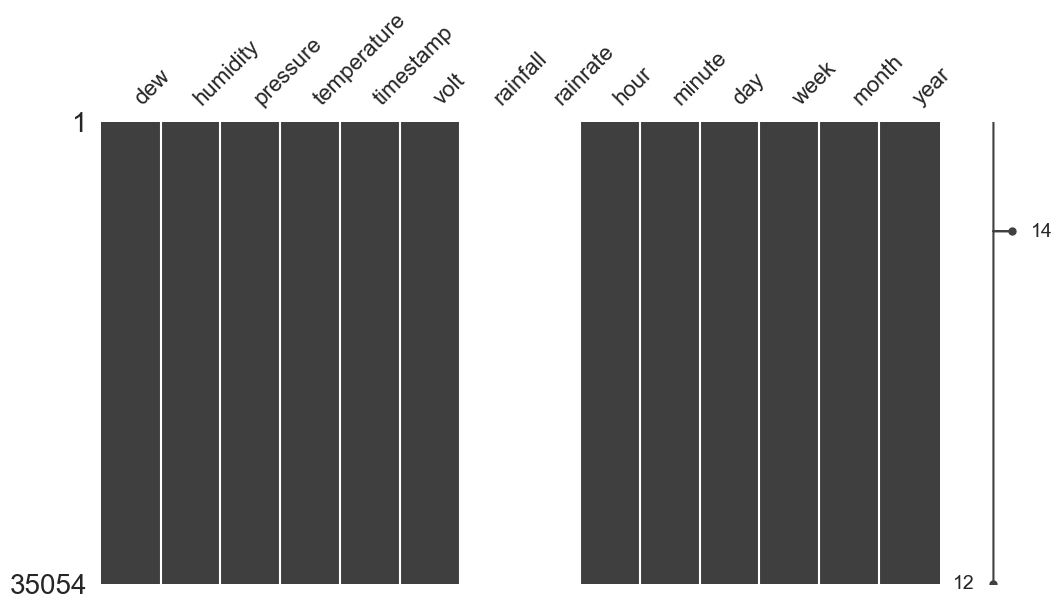


=== Baris dengan Nilai Null ===
Jumlah baris dengan null: 35053

Contoh baris dengan null:
                 dew  humidity  pressure  temperature  \
1761930000  24.54409     98.13   1011.90        24.86   
1761930060  24.51076     98.11   1011.88        24.83   
1761930120  24.54409     98.13   1011.88        24.86   
1761930180  24.55577     98.14   1011.87        24.87   
1761930241  24.54750     98.15   1011.84        24.86   
1761930301  24.54750     98.15   1011.85        24.86   
1761930361  24.56404     98.13   1011.80        24.88   
1761930421  24.54093     98.17   1011.79        24.85   
1761930481  24.53923     98.16   1011.78        24.85   
1761930541  24.54750     98.15   1011.82        24.86   

                           timestamp  volt  rainfall  rainrate  hour  minute  \
1761930000 2025-10-31 17:00:00+00:00  4.10       NaN       NaN    17       0   
1761930060 2025-10-31 17:01:00+00:00  4.10       NaN       NaN    17       1   
1761930120 2025-10-31 17:02:00+00:00  4.

In [49]:
# Mengecek nilai null dalam dataframe cuaca3
print("=== Informasi Missing Values dalam cuaca3 ===\n")
print(cuaca1.isnull().sum())
print("\n" + "="*50 + "\n")

# Menampilkan persentase missing values
print("=== Persentase Missing Values ===\n")
missing_percentage = (cuaca1.isnull().sum() / len(cuaca1)) * 100
print(missing_percentage)
print("\n" + "="*50 + "\n")

# Visualisasi missing values menggunakan missingno
print("=== Visualisasi Missing Values ===")
msno.matrix(cuaca1, figsize=(12, 6))
plt.show()

# Menampilkan baris-baris yang mengandung nilai null
print("\n=== Baris dengan Nilai Null ===")
null_rows = cuaca1[cuaca1.isnull().any(axis=1)]
print(f"Jumlah baris dengan null: {len(null_rows)}")
print("\nContoh baris dengan null:")
print(null_rows.head(10))

=== Informasi Missing Values dalam cuaca3 ===

dew            0
humidity       0
pressure       0
rainfall       0
rainrate       0
temperature    0
timestamp      0
volt           0
hour           0
minute         0
day            0
week           0
month          0
year           0
dtype: int64


=== Persentase Missing Values ===

dew            0.0
humidity       0.0
pressure       0.0
rainfall       0.0
rainrate       0.0
temperature    0.0
timestamp      0.0
volt           0.0
hour           0.0
minute         0.0
day            0.0
week           0.0
month          0.0
year           0.0
dtype: float64


=== Visualisasi Missing Values ===


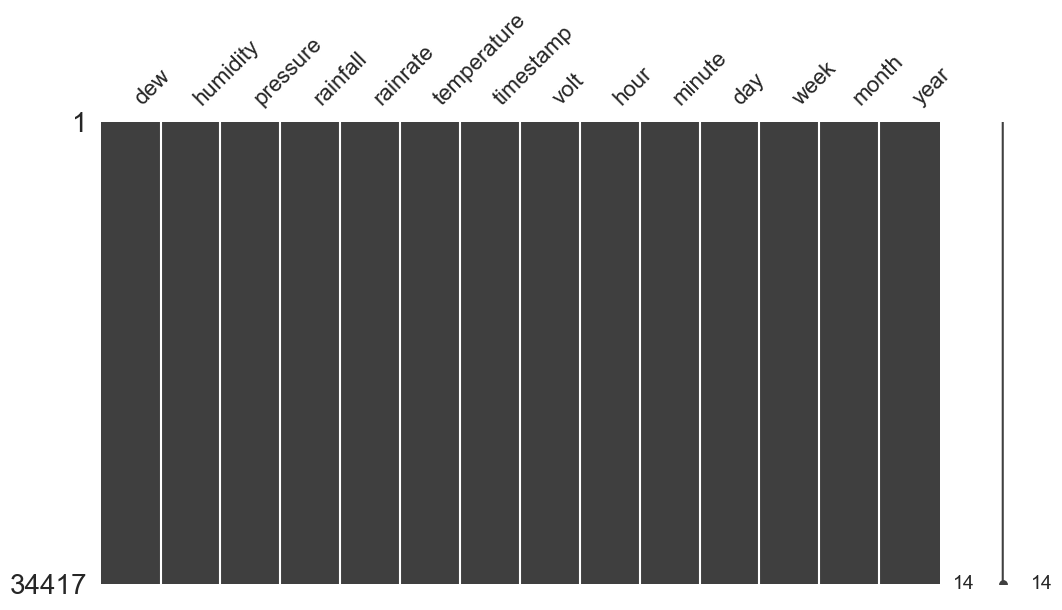


=== Baris dengan Nilai Null ===
Jumlah baris dengan null: 0

Contoh baris dengan null:
Empty DataFrame
Columns: [dew, humidity, pressure, rainfall, rainrate, temperature, timestamp, volt, hour, minute, day, week, month, year]
Index: []


In [50]:
# Mengecek nilai null dalam dataframe cuaca3
print("=== Informasi Missing Values dalam cuaca3 ===\n")
print(cuaca3.isnull().sum())
print("\n" + "="*50 + "\n")

# Menampilkan persentase missing values
print("=== Persentase Missing Values ===\n")
missing_percentage = (cuaca3.isnull().sum() / len(cuaca3)) * 100
print(missing_percentage)
print("\n" + "="*50 + "\n")

# Visualisasi missing values menggunakan missingno
print("=== Visualisasi Missing Values ===")
msno.matrix(cuaca3, figsize=(12, 6))
plt.show()

# Menampilkan baris-baris yang mengandung nilai null
print("\n=== Baris dengan Nilai Null ===")
null_rows = cuaca3[cuaca3.isnull().any(axis=1)]
print(f"Jumlah baris dengan null: {len(null_rows)}")
print("\nContoh baris dengan null:")
print(null_rows.head(10))

In [51]:
cuaca3['timestamp'] = pd.to_datetime(cuaca3['timestamp'])
cuaca3 = cuaca3.set_index('timestamp')

In [52]:
cuaca3.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34417 entries, 2025-10-31 17:00:53+00:00 to 2025-11-25 07:41:06+00:00
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   dew          34417 non-null  float64
 1   humidity     34417 non-null  float64
 2   pressure     34417 non-null  float64
 3   rainfall     34417 non-null  float64
 4   rainrate     34417 non-null  float64
 5   temperature  34417 non-null  float64
 6   volt         34417 non-null  float64
 7   hour         34417 non-null  int32  
 8   minute       34417 non-null  int32  
 9   day          34417 non-null  int32  
 10  week         34417 non-null  int64  
 11  month        34417 non-null  int32  
 12  year         34417 non-null  int32  
dtypes: float64(7), int32(5), int64(1)
memory usage: 3.0 MB


In [53]:
def plot_station_trends(data_dict, column_to_plot, freq='d'):
    """
    Membuat plot tren perbandingan untuk sebuah kolom dari beberapa stasiun cuaca.

    Args:
        data_dict (dict): Dictionary yang berisi {station_id: DataFrame}.
        column_to_plot (str): Nama kolom yang akan di-plot (misal: 'temperature').
        freq (str): Frekuensi untuk pengelompokan data.
                    'd' untuk harian (daily).
                    'h' untuk per jam (hourly).
    """
    # Menentukan label berdasarkan frekuensi
    freq_labels = {
        'd': {'label': 'Harian', 'xlabel': 'Tanggal'},
        'h': {'label': 'Per Jam', 'xlabel': 'Waktu (Jam)'},
        'min': {'label': 'Per Menit', 'xlabel': 'Waktu (Menit)'}
    }
    
    # Pilih label yang sesuai, default ke 'Harian' jika freq tidak dikenali
    selected_freq = freq_labels.get(freq, freq_labels['d'])
    
    # Membuat figure dan axes untuk plot
    plt.figure(figsize=(15, 7))

    # Loop melalui setiap stasiun dalam dictionary
    for station_id, df in data_dict.items():
        if column_to_plot not in df.columns:
            print(f"Peringatan: Kolom '{column_to_plot}' tidak ada di stasiun {station_id}. Dilewati.")
            continue

        temp_df = df.copy()
        
        # Mengelompokkan data berdasarkan frekuensi (harian atau per jam)
        time_group_col = f'time_group_{freq}'
        temp_df[time_group_col] = temp_df['timestamp'].dt.floor(freq)
        trend_data = temp_df.groupby(time_group_col)[column_to_plot].mean().reset_index()

        # Plot data untuk stasiun saat ini
        plt.plot(trend_data[time_group_col], trend_data[column_to_plot], label=station_id, alpha=0.8)

    # Menambahkan detail pada plot
    plt.xlabel(selected_freq['xlabel'])
    plt.ylabel(f"Rata-rata {column_to_plot.capitalize()}")
    plt.title(f"Perbandingan Rata-rata {selected_freq['label']} {column_to_plot.capitalize()} antar Stasiun")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()

    # Menampilkan plot
    plt.show()

In [54]:
# --- 1. PERSIAPAN DATA ---
df = cuaca3.copy()

# Ganti 'timestamp' dengan nama kolom waktu yang sesuai di cuaca3 jika beda
if 'timestamp' in df.columns:
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.set_index('timestamp').sort_index()

# HANDLING TIMEZONE (TETAP UTC)
# Jika data masih polos (naive), kita tempel label UTC.
# Jika sudah ada labelnya, biarkan saja (biasanya raw data itu UTC).
if df.index.tz is None:
    df = df.tz_localize('UTC') 

# [HAPUS/KOMENTARI BARIS INI AGAR TETAP UTC]
# df = df.tz_convert('Asia/Jakarta') 

# --- 2. PROSES HUJAN (WAJIB ISI!) ---
# Logika tetap sama: ffill -> diff -> clip
rain_series = df['rainrate'].resample('1min').ffill()
rain_per_minute = rain_series.diff().fillna(0).clip(lower=0)

# --- 3. PROSES VARIABEL LAIN (BIARKAN KOSONG/JUJUR) ---
# Resample rata-rata per menit
other_vars = df[['temperature', 'humidity', 'pressure', 'dew', 'volt']].resample('1min').mean()

# --- 4. GABUNGKAN KEMBALI ---
data_menit_utc = other_vars.copy()
data_menit_utc['rain_mm'] = rain_per_minute

# Tampilkan Hasil
print("--- Data Menit (Zona Waktu: UTC) ---")
print(data_menit_utc.tail(10))
print("\nCek Timezone Index:")
print(data_menit_utc.index.tz) # Harus output: UTC

--- Data Menit (Zona Waktu: UTC) ---
                           temperature  humidity  pressure       dew     volt  \
timestamp                                                                       
2025-11-25 07:32:00+00:00     33.04303  69.00572   1005.83  26.57687  3.93000   
2025-11-25 07:33:00+00:00     33.13115  67.73540   1005.83  26.34489  3.94250   
2025-11-25 07:34:00+00:00     32.67452  66.49371   1005.84  25.59801  3.94125   
2025-11-25 07:35:00+00:00     32.51431  67.85367   1005.80  25.78804  3.93875   
2025-11-25 07:36:00+00:00     32.52499  68.76158   1005.85  26.02320  3.93750   
2025-11-25 07:37:00+00:00     32.66384  69.34905   1005.83  26.29980  3.93500   
2025-11-25 07:38:00+00:00     32.62112  68.91989   1005.86  26.15375  3.93500   
2025-11-25 07:39:00+00:00     32.58106  68.48119   1005.83  26.00737  3.93500   
2025-11-25 07:40:00+00:00     32.61311  68.88556   1005.75  26.13766  3.93750   
2025-11-25 07:41:00+00:00     32.73861  68.74250   1005.82  26.22195  3.

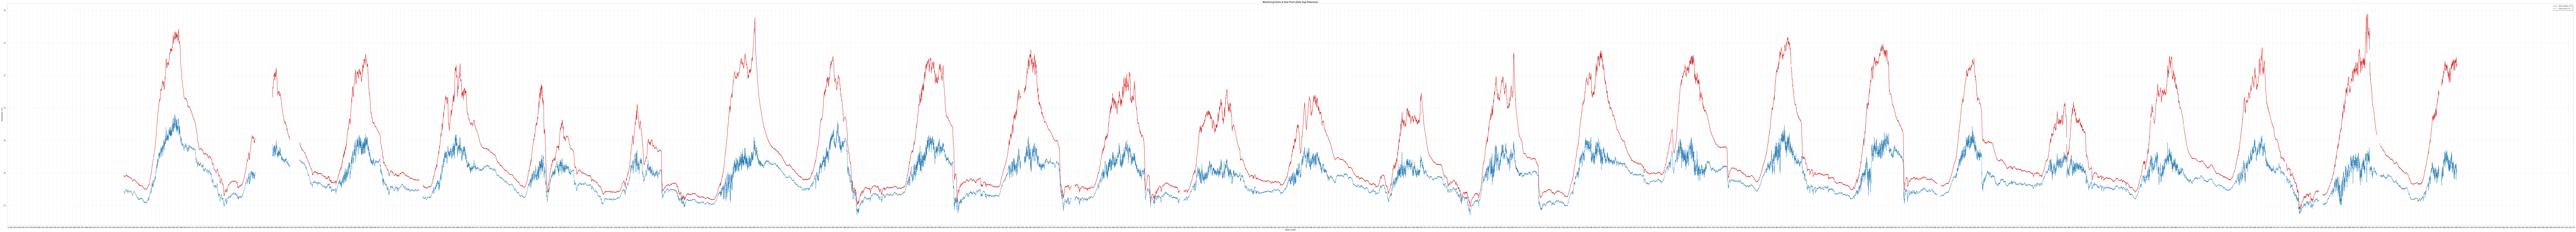

In [55]:
fig, ax = plt.subplots(figsize=(220, 20))

# 1. Plot Suhu (Garis Merah)
# Pandas/Matplotlib otomatis memutus garis jika ketemu NaN
ax.plot(data_menit_utc.index, data_menit_utc['temperature'], 
        color='tab:red', label='Suhu Udara (°C)', linewidth=2)

# 2. Plot Dew Point (Garis Biru Putus-putus)
ax.plot(data_menit_utc.index, data_menit_utc['dew'], 
        color='tab:blue', label='Dew Point (°C)', linestyle='--', linewidth=2)

# 3. Percantik Tampilan
ax.set_title('Monitoring Suhu & Dew Point (Data Gap Detection)', fontsize=14, fontweight='bold')
ax.set_ylabel('Temperatur (°C)', fontsize=12)
ax.set_xlabel('Waktu (WIB)', fontsize=12)
ax.grid(True, which='both', linestyle='--', alpha=0.6)
ax.legend(loc='upper right', frameon=True, shadow=True)

# Format Jam di Sumbu X
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1)) # Label tiap jam (sesuaikan)

plt.tight_layout()
plt.show()

Menampilkan plot perbandingan per jam...


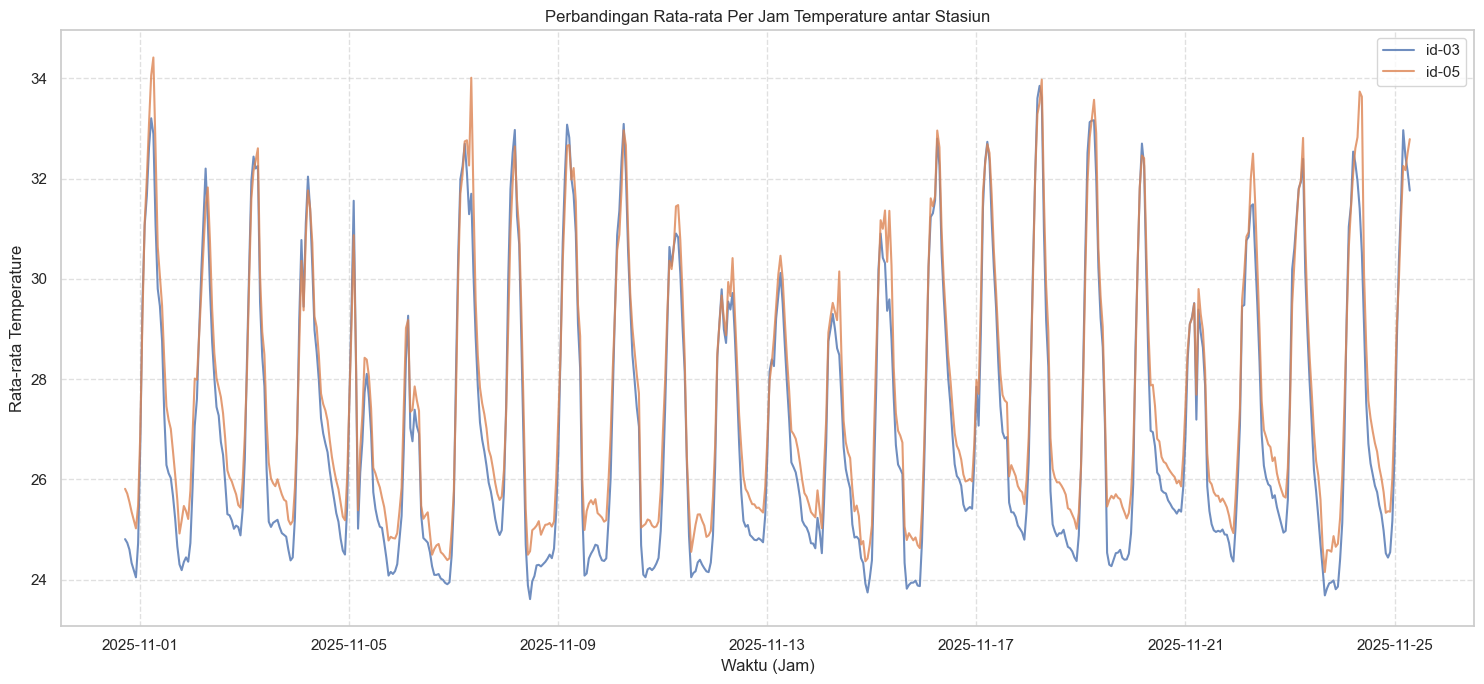

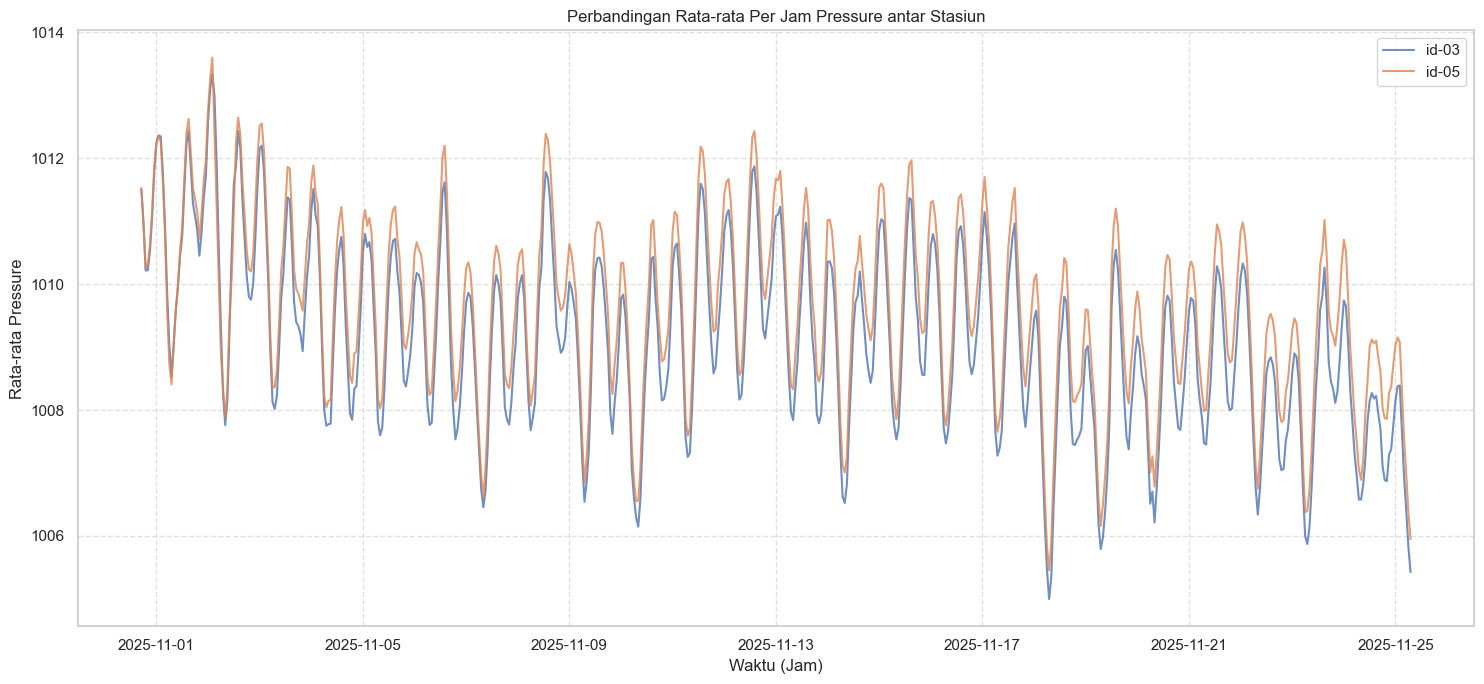

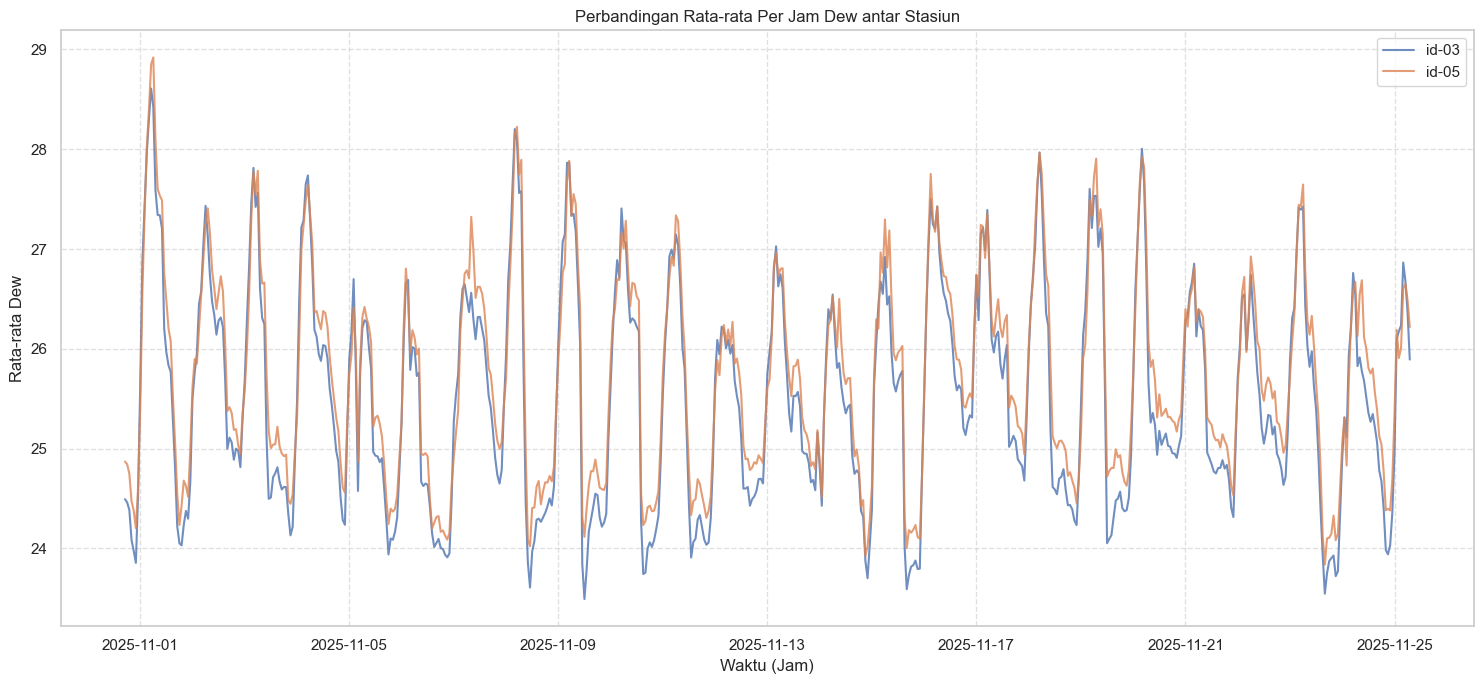

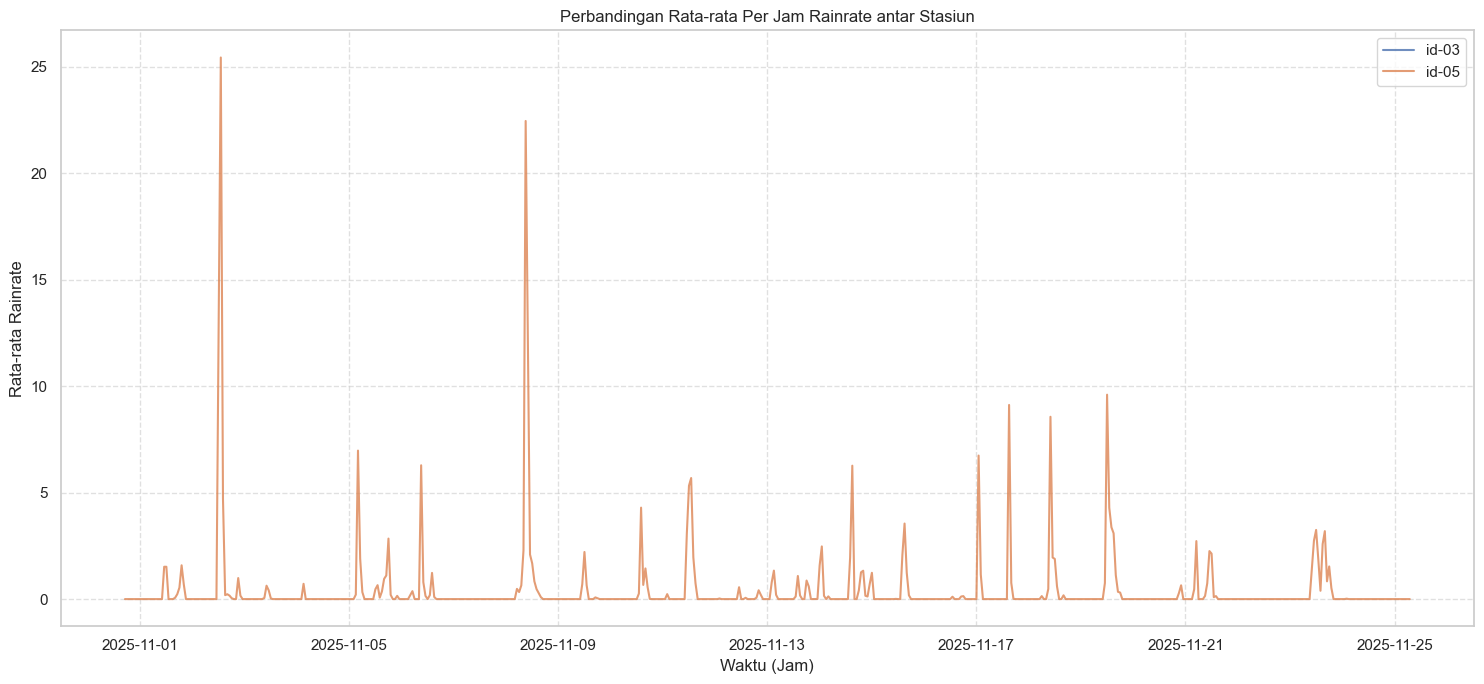


Menampilkan plot perbandingan per hari...


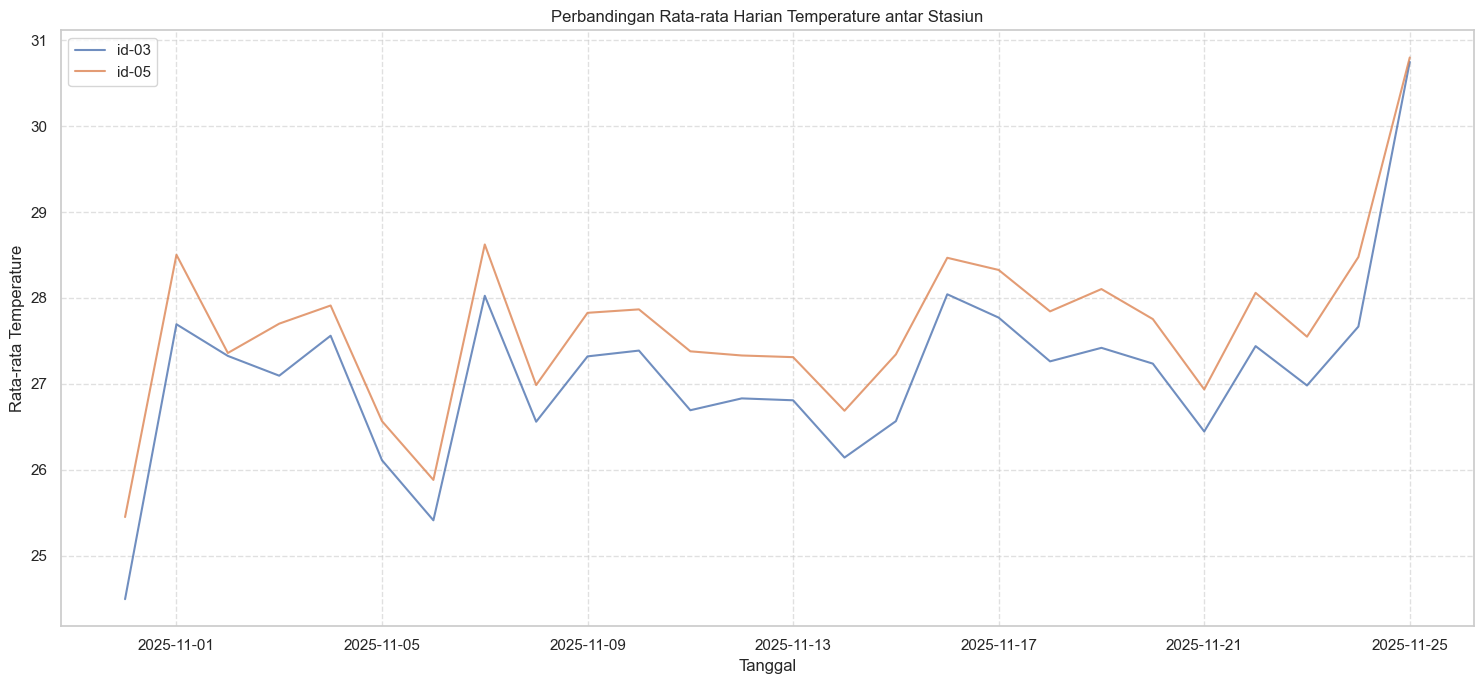

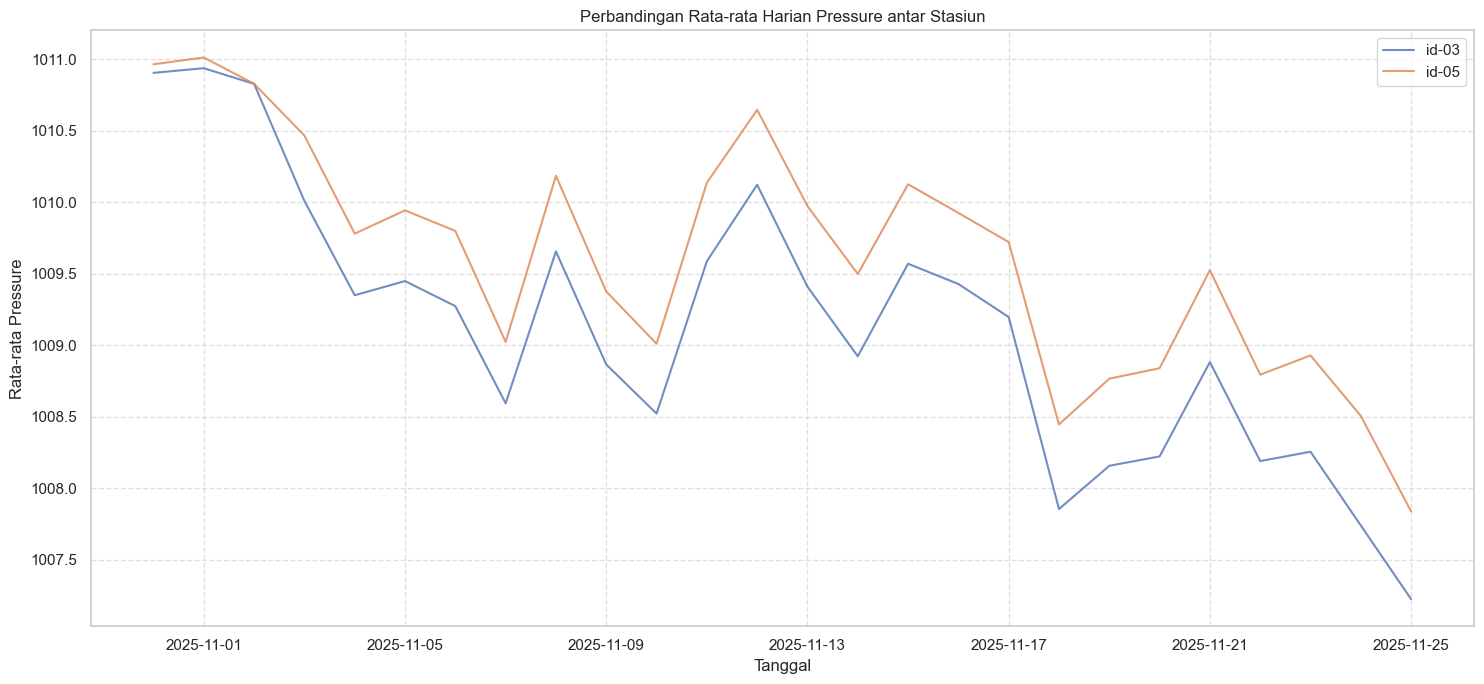

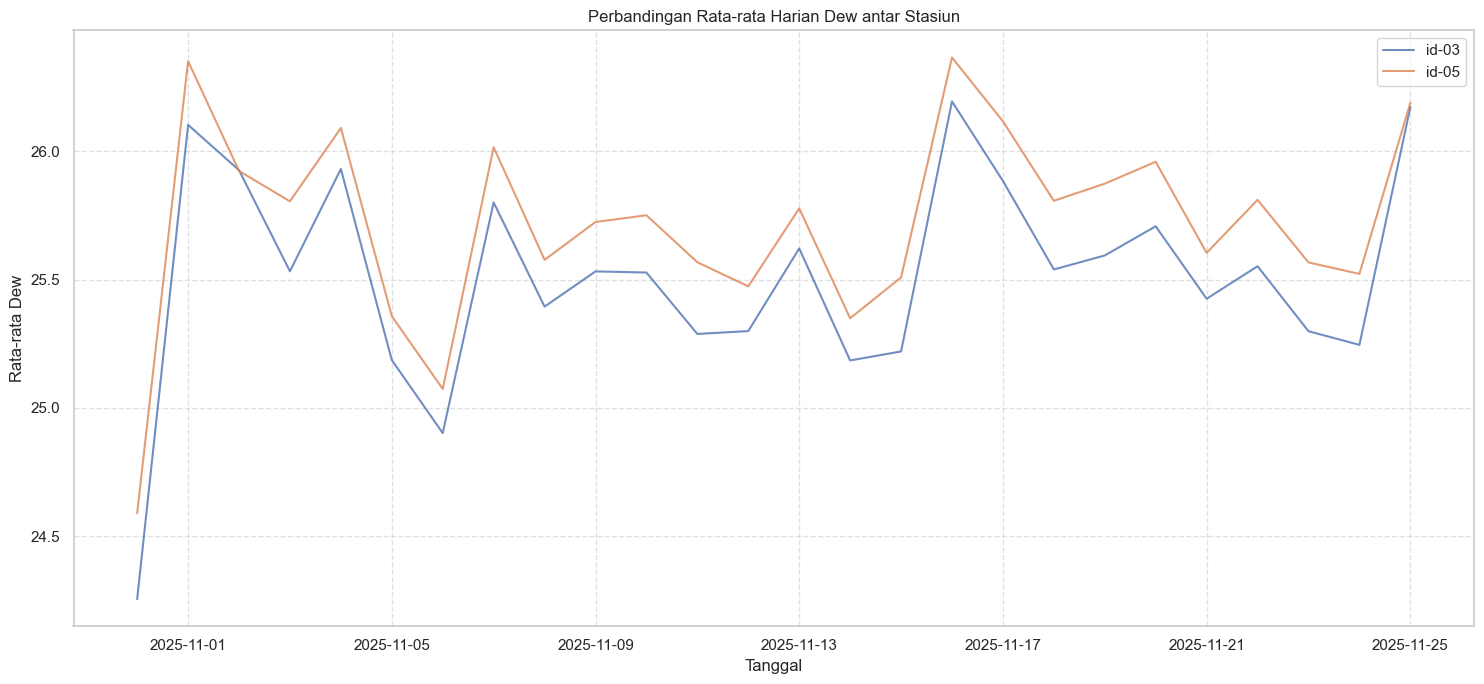

In [56]:
# Membuat Plot Rata-rata PER JAM ---
# Cukup atur freq='h'
print("Menampilkan plot perbandingan per jam...")
plot_station_trends(weather_dataframes, 'temperature', freq='h')
plot_station_trends(weather_dataframes, 'pressure', freq='h')
plot_station_trends(weather_dataframes, 'dew', freq='h')
plot_station_trends(weather_dataframes, 'rainrate', freq='h')


# Membuat Plot Rata-rata PER HARI ---
# Gunakan nilai default freq='d' atau tulis secara eksplisit
print("\nMenampilkan plot perbandingan per hari...")
plot_station_trends(weather_dataframes, 'temperature', freq='d')
plot_station_trends(weather_dataframes, 'pressure', freq='d')
plot_station_trends(weather_dataframes, 'dew', freq='d')

In [57]:

# --- 1. PERSIAPAN DATA ---
df = cuaca3.copy()
if 'timestamp' in df.columns:
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.set_index('timestamp').sort_index()

if df.index.tz is None:
    df = df.tz_localize('UTC')
# Kita proses di UTC dulu biar aman
# (Nanti di visualisasi baru convert ke Asia/Jakarta)

# --- 2. ALGORITMA SMART RESET (Menghitung Hujan Jam-jaman) ---

# A. Pastikan urutan waktu rapat (per menit)
df_menit = df['rainrate'].resample('1min').ffill()

# B. Hitung Selisih
delta = df_menit.diff()

# C. Logika Smart Reset (Handle Reset di tengah jam)
# Jika delta positif -> Hujan biasa
# Jika delta negatif (Reset) -> Ambil nilai saat itu
hujan_murni = np.where(delta >= 0, delta, df_menit)

# D. Masukkan ke DataFrame
df_bersih = pd.DataFrame({'hujan_mm': hujan_murni}, index=df_menit.index).fillna(0)

# E. AGREGASI KE JAM (Pakai SUM karena ini sudah tetesan murni)
jam_hujan = df_bersih['hujan_mm'].resample('h').sum()

# --- 3. PROSES SUHU (Tetap pakai Mean/Max/Min) ---
suhu_data = df['temperature'].resample('h') # Grouping dulu
suhu_rata = suhu_data.mean()
suhu_maks = suhu_data.max()
suhu_mini = suhu_data.min()

# --- 4. GABUNGKAN JADI DATAFRAME UTAMA ---
data_meteorologi = pd.DataFrame({
    'laju_hujan': jam_hujan,  # Ini hasil Smart Reset (.sum)
    'rata_suhu': suhu_rata,
    'suhu_maks': suhu_maks,
    'suhu_mini': suhu_mini
})

# Interpolasi suhu yang bolong
data_meteorologi[['rata_suhu', 'suhu_maks', 'suhu_mini']] = \
    data_meteorologi[['rata_suhu', 'suhu_maks', 'suhu_mini']].interpolate(method='time')

print("--- Data Siap (Metode Smart Reset) ---")
print(data_meteorologi.tail(10))

--- Data Siap (Metode Smart Reset) ---
                           laju_hujan  rata_suhu  suhu_maks  suhu_mini
timestamp                                                             
2025-11-24 22:00:00+00:00         0.0  25.357291   25.49401   25.28573
2025-11-24 23:00:00+00:00         0.0  26.016772   26.63157   25.53674
2025-11-25 00:00:00+00:00         0.0  27.305917   28.07355   26.66628
2025-11-25 01:00:00+00:00         0.0  29.018756   29.64904   28.03349
2025-11-25 02:00:00+00:00         0.0  29.973487   30.71183   29.33662
2025-11-25 03:00:00+00:00         0.0  31.222646   31.80400   30.74387
2025-11-25 04:00:00+00:00         0.0  32.255373   32.87747   31.49691
2025-11-25 05:00:00+00:00         0.0  32.170901   32.66384   31.55566
2025-11-25 06:00:00+00:00         0.0  32.510123   32.99496   31.57168
2025-11-25 07:00:00+00:00         0.0  32.789287   33.13115   32.33273


In [58]:
data_meteorologi["laju_hujan"].sum()

np.float64(478.3327999999999)

In [59]:
data_meteorologi.tail(50)

laju_hujan  rata_suhu  suhu_maks  suhu_mini
timestamp                                                             
2025-11-23 06:00:00+00:00      0.0000  32.814450   33.71061   32.03899
2025-11-23 07:00:00+00:00      0.0000  30.797284   32.38880   29.87068
2025-11-23 08:00:00+00:00      0.0000  29.396786   29.88937   28.93607
2025-11-23 09:00:00+00:00      0.0000  28.451935   28.96544   28.03883
2025-11-23 10:00:00+00:00      4.4704  27.713233   28.06020   27.28313
2025-11-23 11:00:00+00:00      5.5880  26.936167   27.29115   26.73037
2025-11-23 12:00:00+00:00      5.0292  26.366030   26.78111   26.10284
2025-11-23 13:00:00+00:00      3.0734  26.074808   26.32182   25.79576
2025-11-23 14:00:00+00:00      0.2794  25.597531   25.98535   25.32044
2025-11-23 15:00:00+00:00      9.7790  24.640574   25.35783   23.77699
2025-11-23 16:00:00+00:00      4.4704  24.152705   24.54337   23.75029
2025-11-23 17:00:00+00:00      1.1176  24.588056   24.72495   24.41787
2025-11-23 18:00:00+00:00      3.9116  24.586543   24.78104   24.30038
2025-11-23 19:00:00+00:00      0.0000  24.558595   24.86649   24.18021
2025-11-23 20:00:00+00:00      0.0000  24.869505   24.94392   24.79706
2025-11-23 21:00:00+00:00      0.0000  24.656791   24.67689   24.63149
2025-11-23 22:00:00+00:00      0.0000  24.718456   24.92256   24.61814
2025-11-23 23:00:00+00:00      0.0000  25.225122   25.60082   24.90387
2025-11-24 00:00:00+00:00      0.0000  26.081394   26.78645   25.55810
2025-11-24 01:00:00+00:00      0.0000  27.503522   28.32456   26.79980
2025-11-24 02:00:00+00:00      0.2794  29.034066   30.01221   28.15633
2025-11-24 03:00:00+00:00      0.0000  30.626560   31.25925   29.70779
2025-11-24 04:00:00+00:00      0.0000  31.411505   31.92416   30.94148
2025-11-24 05:00:00+00:00      0.0000  32.105474   32.55703   31.58236
2025-11-24 06:00:00+00:00      0.0000  32.603851   33.54772   31.96155
2025-11-24 07:00:00+00:00      0.0000  32.828337   33.62516   32.14580
2025-11-24 08:00:00+00:00      0.0000  33.738918   35.72938   32.44221
2025-11-24 09:00:00+00:00      0.0000  33.637201   35.78546   31.42214
2025-11-24 10:00:00+00:00      0.0000  30.109407   31.34737   29.05623
2025-11-24 11:00:00+00:00      0.0000  28.661516   29.02686   28.34325
2025-11-24 12:00:00+00:00      0.0000  27.568674   27.79851   27.40597
2025-11-24 13:00:00+00:00      0.0000  27.219755   27.43267   27.02945
2025-11-24 14:00:00+00:00      0.0000  26.958153   27.06683   26.83185
2025-11-24 15:00:00+00:00      0.0000  26.725712   26.86389   26.53811
2025-11-24 16:00:00+00:00      0.0000  26.555732   26.67429   26.35386
2025-11-24 17:00:00+00:00      0.0000  26.238945   26.36454   26.10551
2025-11-24 18:00:00+00:00      0.0000  26.025405   26.11620   25.95865
2025-11-24 19:00:00+00:00      0.0000  25.746535   25.98535   25.40856
2025-11-24 20:00:00+00:00      0.0000  25.335603   25.40589   25.28306
2025-11-24 21:00:00+00:00      0.0000  25.365838   25.41657   25.28306
2025-11-24 22:00:00+00:00      0.0000  25.357291   25.49401   25.28573
2025-11-24 23:00:00+00:00      0.0000  26.016772   26.63157   25.53674
2025-11-25 00:00:00+00:00      0.0000  27.305917   28.07355   26.66628
2025-11-25 01:00:00+00:00      0.0000  29.018756   29.64904   28.03349
2025-11-25 02:00:00+00:00      0.0000  29.973487   30.71183   29.33662
2025-11-25 03:00:00+00:00      0.0000  31.222646   31.80400   30.74387
2025-11-25 04:00:00+00:00      0.0000  32.255373   32.87747   31.49691
2025-11-25 05:00:00+00:00      0.0000  32.170901   32.66384   31.55566
2025-11-25 06:00:00+00:00      0.0000  32.510123   32.99496   31.57168
2025-11-25 07:00:00+00:00      0.0000  32.789287   33.13115   32.33273

In [60]:
# Langkah 1: Resample data untuk mendapatkan nilai 'rainrate' maksimum per hari.
# Langkah 2: Resample harian (cut-off 00:00 UTC / 07:00 WIB)
hujan_harian = data_meteorologi['laju_hujan'].resample('d').sum()

# Langkah 3: Hitung statistik suhu harian
# Menggunakan UTC agar sinkron dengan periode hujan
suhu_data = data_meteorologi['rata_suhu']
suhu_rata_harian = suhu_data.resample('d').mean()
suhu_maks_harian = suhu_data.resample('d').max()
suhu_mini_harian = suhu_data.resample('d').min()

# Gabungkan ke DataFrame
data_klimat = pd.DataFrame({
    'curah_hujan': hujan_harian,
    'rata_suhu': suhu_rata_harian,
    'suhu_maks': suhu_maks_harian,
    'suhu_mini': suhu_mini_harian
})

# Kembalikan index ke WIB
#data_klimat = data_klimat.tz_convert('Asia/Jakarta')

# --- FILTER TANGGAL AGAR RAPI ---
# Menggunakan start_readable_date dan end_readable_date dari input pengguna
# Format asumsi: "DD-MM-YYYY HH:MM:SS"
#start_ts = pd.to_datetime(start_readable_date, dayfirst=True).tz_localize('Asia/Jakarta').floor('D')
#end_ts = pd.to_datetime(end_readable_date, dayfirst=True).tz_localize('Asia/Jakarta').ceil('D')

# Potong data yang di luar rentang
#data_klimat = data_klimat.loc[(data_klimat.index >= start_ts) & (data_klimat.index < end_ts)]

In [61]:
data_klimat.tail(20)

curah_hujan  rata_suhu  suhu_maks  suhu_mini
timestamp                                                              
2025-11-06 00:00:00+00:00      23.1902  25.877902  29.179865  24.390900
2025-11-07 00:00:00+00:00       0.2794  28.619283  34.015119  25.591654
2025-11-08 00:00:00+00:00      93.0402  26.978945  32.645507  24.498067
2025-11-09 00:00:00+00:00       8.3820  27.822171  32.670163  24.992256
2025-11-10 00:00:00+00:00      13.9700  27.882089  32.966302  25.039966
2025-11-11 00:00:00+00:00      42.7482  27.284960  31.474234  24.555820
2025-11-12 00:00:00+00:00       5.3086  27.310656  30.416332  25.339688
2025-11-13 00:00:00+00:00      13.4112  27.310357  30.462869  25.243724
2025-11-14 00:00:00+00:00      33.8074  26.685707  30.150174  24.367404
2025-11-15 00:00:00+00:00      10.6172  27.342365  31.366381  24.629980
2025-11-16 00:00:00+00:00       1.6764  28.461050  32.961318  25.960075
2025-11-17 00:00:00+00:00      21.7932  28.321011  32.689745  25.508965
2025-11-18 00:00:00+00:00      26.2636  27.855797  33.976221  25.014687
2025-11-19 00:00:00+00:00      51.9684  27.986871  33.574692  25.221542
2025-11-20 00:00:00+00:00       1.1176  27.753508  32.463481  25.861896
2025-11-21 00:00:00+00:00      16.7640  26.931396  29.798759  24.929771
2025-11-22 00:00:00+00:00       0.0000  28.068486  32.501309  25.638029
2025-11-23 00:00:00+00:00      37.7190  27.428444  32.814450  24.152705
2025-11-24 00:00:00+00:00       0.2794  28.477340  33.738918  25.335603
2025-11-25 00:00:00+00:00       0.0000  30.905811  32.789287  27.305917

Grafik Hourly berhasil disimpan di: plots\Meteo_Chart_Hourly_id-05_2025-11-01_sd_2025-11-25.png


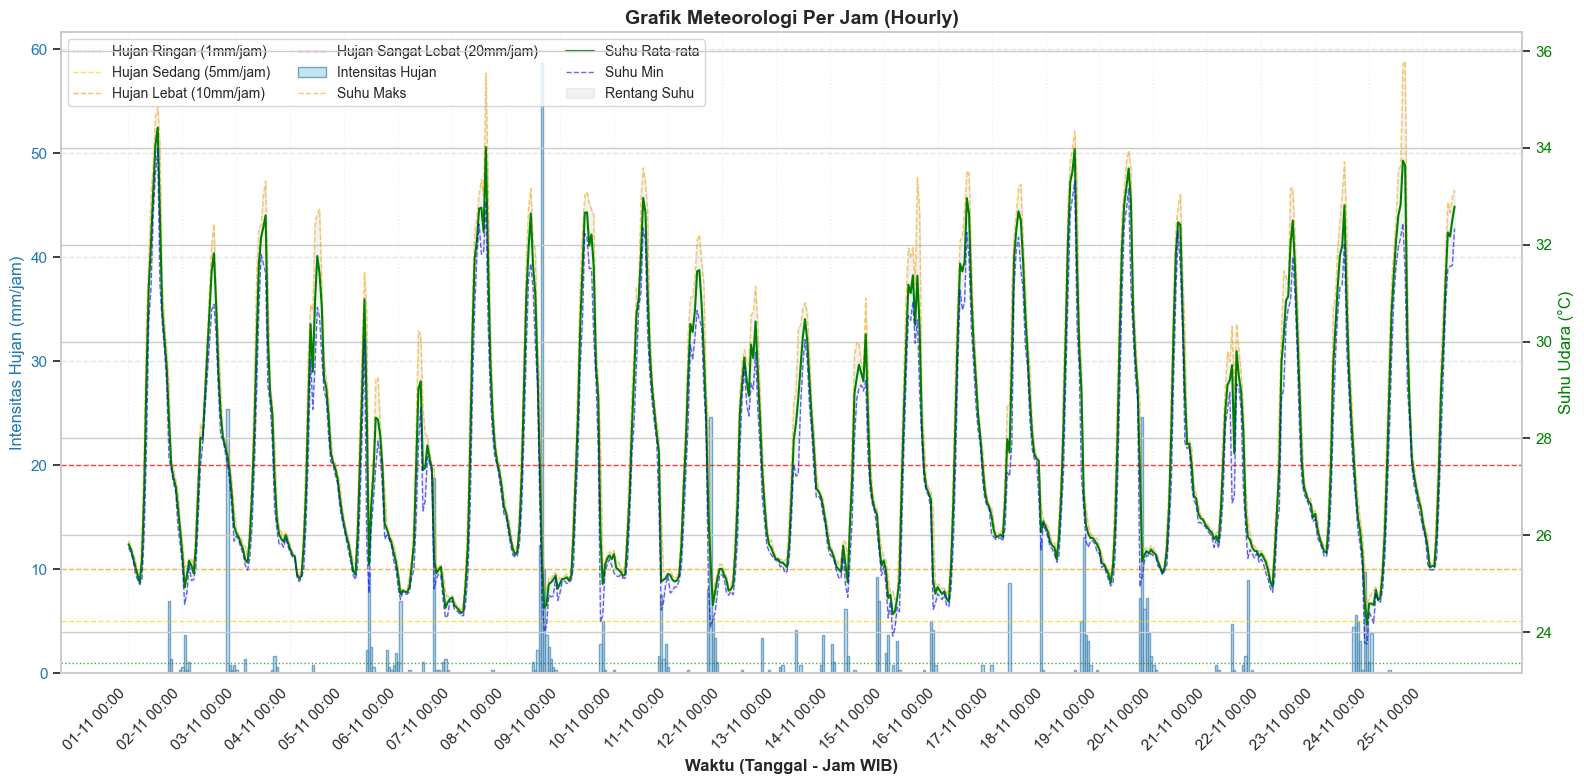

In [62]:
# --- VISUALISASI DATA PER JAM (HOURLY) ---

# 1. Persiapan Data
# Copy data agar tidak merusak variabel asli
df_plot_hourly = data_meteorologi.copy()

# Konversi ke WIB (Asia/Jakarta) agar jam sesuai dengan waktu lokal
# Cek apakah index sudah punya timezone
if df_plot_hourly.index.tz is None:
	# Jika naive, asumsikan UTC (karena output resample sebelumnya UTC) lalu convert
	df_plot_hourly = df_plot_hourly.tz_localize('UTC').tz_convert('Asia/Jakarta')
else:
	# Jika sudah aware, langsung convert
	df_plot_hourly = df_plot_hourly.tz_convert('Asia/Jakarta')

# Filter tanggal sesuai rentang yang ditentukan sebelumnya (start_ts, end_ts dari Cell 22)
# Pastikan start_ts dan end_ts ada, jika tidak skip filter
try:
	df_plot_hourly = df_plot_hourly.loc[(df_plot_hourly.index >= start_iso) & (df_plot_hourly.index < end_iso)]
except NameError:
	print("Variabel start_ts/end_ts tidak ditemukan, menampilkan semua data.")

# 2. Setup Plot
fig, ax1 = plt.subplots(figsize=(16, 8)) # Lebar diperbesar karena data per jam padat

# Buat array X-axis (angka urut) agar bar chart rapi
x_axis = range(len(df_plot_hourly))
# Buat label tanggal string untuk tick
date_labels = df_plot_hourly.index.strftime('%d-%m %H:%M')

# 3. Plot Curah Hujan (Bar chart) di ax1
# Gunakan 'laju_hujan' dari data_meteorologi
ax1.bar(x_axis, df_plot_hourly['laju_hujan'], color='lightblue', edgecolor='steelblue', label='Intensitas Hujan', alpha=0.7, width=1.0)

ax1.set_xlabel('Waktu (Tanggal - Jam WIB)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Intensitas Hujan (mm/jam)', fontsize=12, color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Atur X-Ticks: Tampilkan label setiap 24 jam (sehari sekali) agar tidak tumpang tindih
# atau setiap 12 jam jika rentang data pendek. Kita coba setiap 24 jam.
interval_tick = 24 
ax1.set_xticks(x_axis[::interval_tick])
ax1.set_xticklabels(date_labels[::interval_tick], rotation=45, ha='right')

# Garis batas kategori hujan PER JAM (BMKG)
# Kategori intensitas hujan per jam: Ringan (1-5), Sedang (5-10), Lebat (10-20), Sangat Lebat (>20)
ax1.axhline(y=1, color='green', linestyle=':', linewidth=1, alpha=0.7, label='Hujan Ringan (1mm/jam)')
ax1.axhline(y=5, color='gold', linestyle='--', linewidth=1, alpha=0.7, label='Hujan Sedang (5mm/jam)')
ax1.axhline(y=10, color='orange', linestyle='--', linewidth=1, alpha=0.7, label='Hujan Lebat (10mm/jam)')
ax1.axhline(y=20, color='red', linestyle='--', linewidth=1, alpha=0.7, label='Hujan Sangat Lebat (20mm/jam)')

# 4. Membuat secondary y-axis (ax2) untuk Suhu
ax2 = ax1.twinx()

# A. Plot Suhu Maksimum (Jingga)
ax2.plot(x_axis, df_plot_hourly['suhu_maks'], color='orange', linestyle='--', linewidth=1, alpha=0.6, label='Suhu Maks')

# B. Plot Suhu Rata-rata (Hijau)
ax2.plot(x_axis, df_plot_hourly['rata_suhu'], color='green', linewidth=1.5, label='Suhu Rata-rata')

# C. Plot Suhu Minimum (Biru)
ax2.plot(x_axis, df_plot_hourly['suhu_mini'], color='blue', linestyle='--', linewidth=1, alpha=0.6, label='Suhu Min')

# D. Arsiran Rentang Suhu
ax2.fill_between(x_axis, df_plot_hourly['suhu_mini'], df_plot_hourly['suhu_maks'], color='gray', alpha=0.1, label='Rentang Suhu')

ax2.set_ylabel('Suhu Udara (°C)', fontsize=12, color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Judul dan Grid
ax1.set_title('Grafik Meteorologi Per Jam (Hourly)', fontsize=14, fontweight='bold')
ax1.grid(axis='y', linestyle='--', alpha=0.5)
ax1.grid(axis='x', linestyle=':', alpha=0.3)

# Menggabungkan Legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', bbox_to_anchor=(0, 1), ncol=3, fontsize='small', frameon=True)

plt.tight_layout()

# --- Menyimpan Plot ---
output_folder = 'plots'
if not os.path.exists(output_folder):
	os.makedirs(output_folder)

tgl_awal_str = df_plot_hourly.index[0].strftime('%Y-%m-%d')
tgl_akhir_str = df_plot_hourly.index[-1].strftime('%Y-%m-%d')
filename_hourly = f"Meteo_Chart_Hourly_id-05_{tgl_awal_str}_sd_{tgl_akhir_str}.png"
filepath_hourly = os.path.join(output_folder, filename_hourly)

plt.savefig(filepath_hourly, dpi=300)
print(f"Grafik Hourly berhasil disimpan di: {filepath_hourly}")

plt.show()


Grafik berhasil disimpan di: plots\Meteo_Chart_id-05_2025-10-31_sd_2025-11-25.png


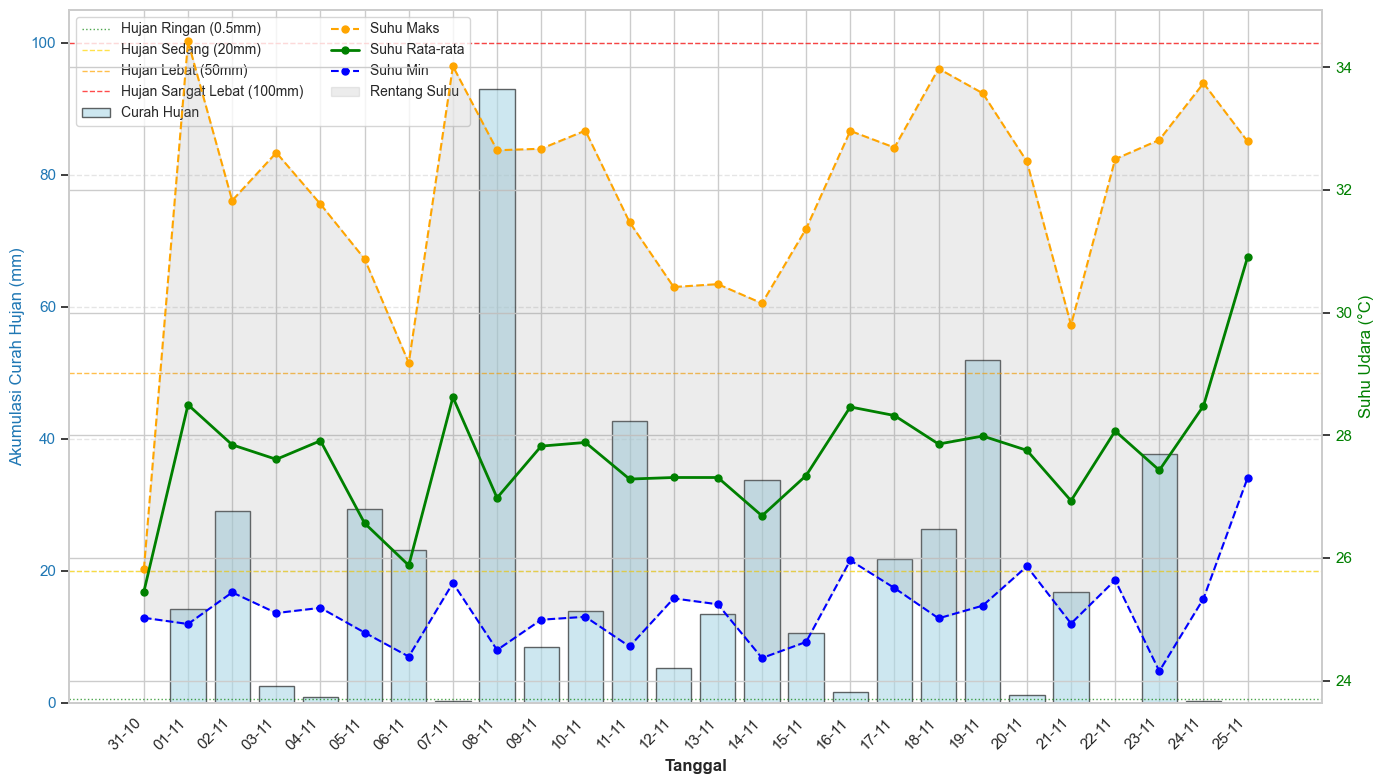

In [63]:
# --- VISUALISASI BARU ---

fig, ax1 = plt.subplots(figsize=(14, 8))

# 1. Plot Curah Hujan (Bar chart) di ax1
# Gunakan format tanggal string untuk sumbu X agar rapi
date_labels = data_klimat.index.strftime('%d-%m') 
ax1.bar(date_labels, data_klimat['curah_hujan'], color='lightblue', edgecolor='black', label='Curah Hujan', alpha=0.6)

ax1.set_xlabel('Tanggal', fontsize=12, fontweight='bold')
ax1.set_ylabel('Akumulasi Curah Hujan (mm)', fontsize=12, color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Memiringkan label tanggal agar tidak tumpang tindih
plt.xticks(rotation=45, ha='right')

# Garis batas kategori hujan (BMKG)
ax1.axhline(y=0.5, color='green', linestyle=':', linewidth=1, alpha=0.7, label='Hujan Ringan (0.5mm)')
ax1.axhline(y=20, color='gold', linestyle='--', linewidth=1, alpha=0.7, label='Hujan Sedang (20mm)')
ax1.axhline(y=50, color='orange', linestyle='--', linewidth=1, alpha=0.7, label='Hujan Lebat (50mm)')
ax1.axhline(y=100, color='red', linestyle='--', linewidth=1, alpha=0.7, label='Hujan Sangat Lebat (100mm)')

# 2. Membuat secondary y-axis (ax2) untuk Suhu
ax2 = ax1.twinx()

# Kita plot garis menggunakan range(len) agar pas di tengah bar chart
x_axis = range(len(data_klimat))

# A. Plot Suhu Maksimum (Jingga)
ax2.plot(x_axis, data_klimat['suhu_maks'], color='orange', linestyle='--', marker='o', markersize=5, label='Suhu Maks')

# B. Plot Suhu Rata-rata (Hijau)
ax2.plot(x_axis, data_klimat['rata_suhu'], color='green', linewidth=2, marker='o', markersize=5, label='Suhu Rata-rata')

# C. Plot Suhu Minimum (Biru)
ax2.plot(x_axis, data_klimat['suhu_mini'], color='blue', linestyle='--', marker='o', markersize=5, label='Suhu Min')

# D. Arsiran Rentang Suhu (Diurnal Range) - Opsional tapi Bagus
# Memberikan efek visual rentang suhu hari itu
ax2.fill_between(x_axis, data_klimat['suhu_mini'], data_klimat['suhu_maks'], color='gray', alpha=0.15, label='Rentang Suhu')
ax2.set_ylabel('Suhu Udara (°C)', fontsize=12, color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Judul dan Grid
ax1.grid(axis='y', linestyle='--', alpha=0.5)

# Menggabungkan Legend dari kedua axis agar rapi
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
# Taruh legend di luar plot atau di posisi kosong
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', bbox_to_anchor=(0, 1), ncol=2, fontsize='small', frameon=True)

plt.tight_layout()

# --- Menyimpan Plot ---
output_folder = 'plots'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Ambil tanggal awal dan akhir dari index dataframe langsung (lebih aman)
tgl_awal = data_klimat.index[0].strftime('%Y-%m-%d')
tgl_akhir = data_klimat.index[-1].strftime('%Y-%m-%d')
filename = f"Meteo_Chart_id-05_{tgl_awal}_sd_{tgl_akhir}.png"
filepath = os.path.join(output_folder, filename)

plt.savefig(filepath, dpi=300)
print(f"Grafik berhasil disimpan di: {filepath}")

plt.show()

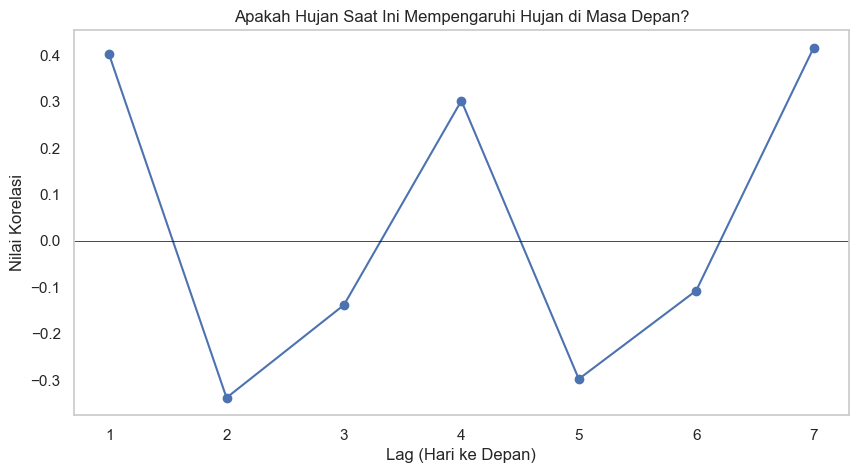

In [64]:
# Anggap df_hujan punya kolom 'temperature' dan 'rainrate'

hasil_korelasi = []
max_lag = 7 # Cek sampai 48 jam ke depan

for i in range(1, max_lag + 1):
    # Korelasi: Suhu SEKARANG vs Hujan 'i' JAM KEMUDIAN
    # Kita shift hujan ke atas (masa depan ditarik ke sekarang)
    future_rain = data_klimat['curah_hujan'].shift(-i)
    
    corr = data_klimat['rata_suhu'].corr(future_rain)
    hasil_korelasi.append(corr)
    
# Plot hasilnya
plt.figure(figsize=(10, 5))
plt.plot(range(1, max_lag + 1), hasil_korelasi, marker='o')
plt.axhline(0, color='black', linewidth=0.5)
plt.xlabel('Lag (Hari ke Depan)')
plt.ylabel('Nilai Korelasi')
plt.title('Apakah Hujan Saat Ini Mempengaruhi Hujan di Masa Depan?')
plt.grid()
plt.show()

Text(0.5, 0, 'Lama Hujan (Jam)')

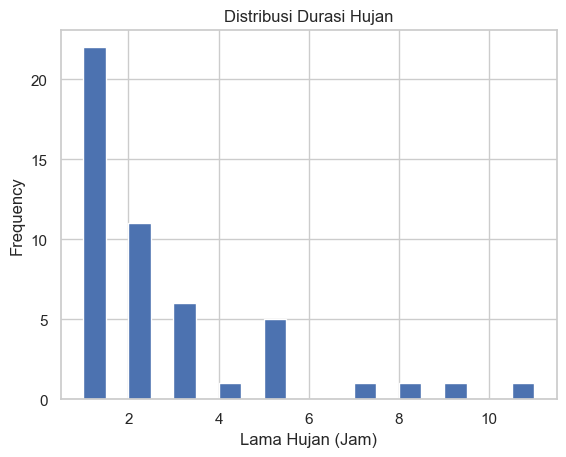

In [65]:
# Logika untuk mengelompokkan jam hujan berturut-turut
# (Kode agak kompleks, ini logika intinya)
data_meteorologi['is_rain'] = data_meteorologi['laju_hujan'] > 0
# Memberi ID unik untuk setiap blok kejadian hujan
data_meteorologi['storm_id'] = (data_meteorologi['is_rain'] != data_meteorologi['is_rain'].shift()).cumsum()

# Filter hanya yang hujan
badai = data_meteorologi[data_meteorologi['is_rain']].groupby('storm_id')

# Hitung durasi setiap badai
durasi_badai = badai.size()  # Dalam jam (karena data per jam)

# Histogram Durasi
durasi_badai.plot(kind='hist', bins=20, title='Distribusi Durasi Hujan')
plt.xlabel('Lama Hujan (Jam)')

Total Data Harian: 26 hari
Jumlah Hari Hujan: 21
Jumlah Hari Kering: 5

Matriks Kejadian (Count):
[[ 1.  3.]
 [ 3. 18.]]


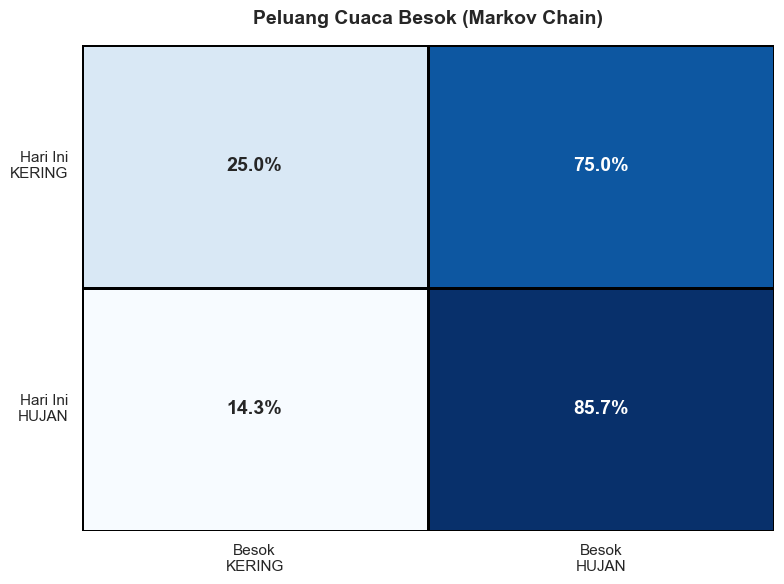

In [66]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. PERSIAPAN DATA ---
# Gunakan threshold 0.5 mm agar lebih valid secara meteorologis
threshold_hujan = 0.5
status_hujan = data_klimat['curah_hujan'].apply(lambda x: 1 if x >= threshold_hujan else 0).values

print(f"Total Data Harian: {len(status_hujan)} hari")
print(f"Jumlah Hari Hujan: {np.sum(status_hujan)}")
print(f"Jumlah Hari Kering: {len(status_hujan) - np.sum(status_hujan)}")

# --- 2. HITUNG TRANSISI (MANUAL) ---
jumlah_transisi = np.zeros((2, 2)) 

for t in range(len(status_hujan) - 1):
    state_sekarang = status_hujan[t]      
    state_besok    = status_hujan[t + 1]  
    jumlah_transisi[state_sekarang][state_besok] += 1

print("\nMatriks Kejadian (Count):")
print(jumlah_transisi)

# --- 3. HITUNG PROBABILITAS ---
matriks_probabilitas = np.zeros((2, 2))
total_per_state = jumlah_transisi.sum(axis=1)

for i in range(2):
    if total_per_state[i] > 0: # Mencegah bagi dengan nol
        for j in range(2):
            matriks_probabilitas[i][j] = jumlah_transisi[i][j] / total_per_state[i]

# --- 4. VISUALISASI ---
df_plot = pd.DataFrame(matriks_probabilitas, 
                       index=['Hari Ini\nKERING', 'Hari Ini\nHUJAN'],
                       columns=['Besok\nKERING', 'Besok\nHUJAN'])

plt.figure(figsize=(8, 6))
sns.heatmap(df_plot, 
            annot=True, 
            fmt=".1%", # 1 desimal cukup (contoh: 58.3%)
            cmap="Blues", 
            linewidths=1, 
            linecolor='black',
            cbar=False, # Hilangkan colorbar biar simpel
            annot_kws={"size": 14, "weight": "bold"})

plt.title('Peluang Cuaca Besok (Markov Chain)', fontsize=14, fontweight='bold', pad=15)
plt.yticks(rotation=0) 
plt.tight_layout()
plt.show()

--- Statistik Diurnal (WIB) ---
     Total Intensitas  Frekuensi
jam                             
0              5.5880          8
1             19.5580          6
2              5.5880          4
3              1.9558          2
4              3.0734          3


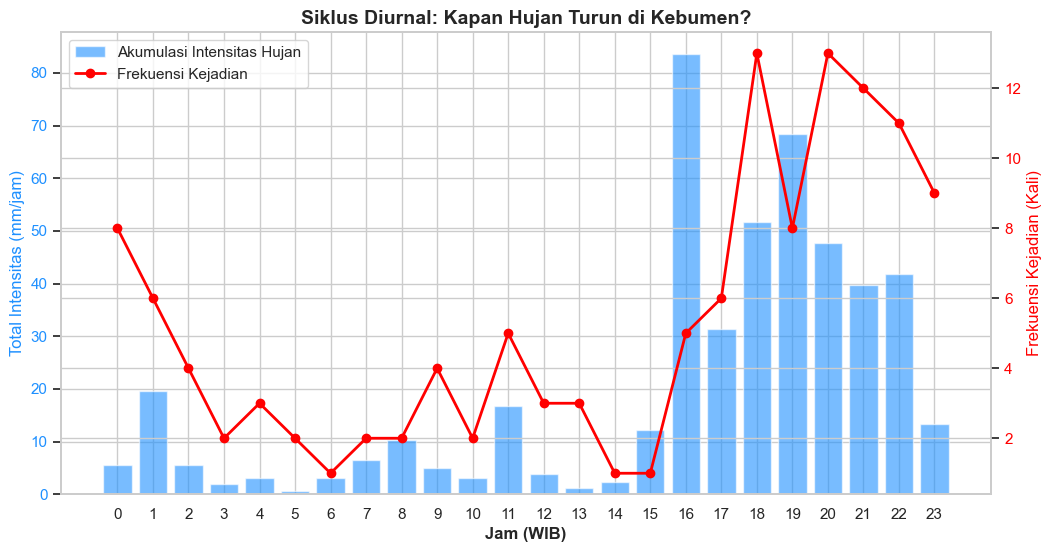

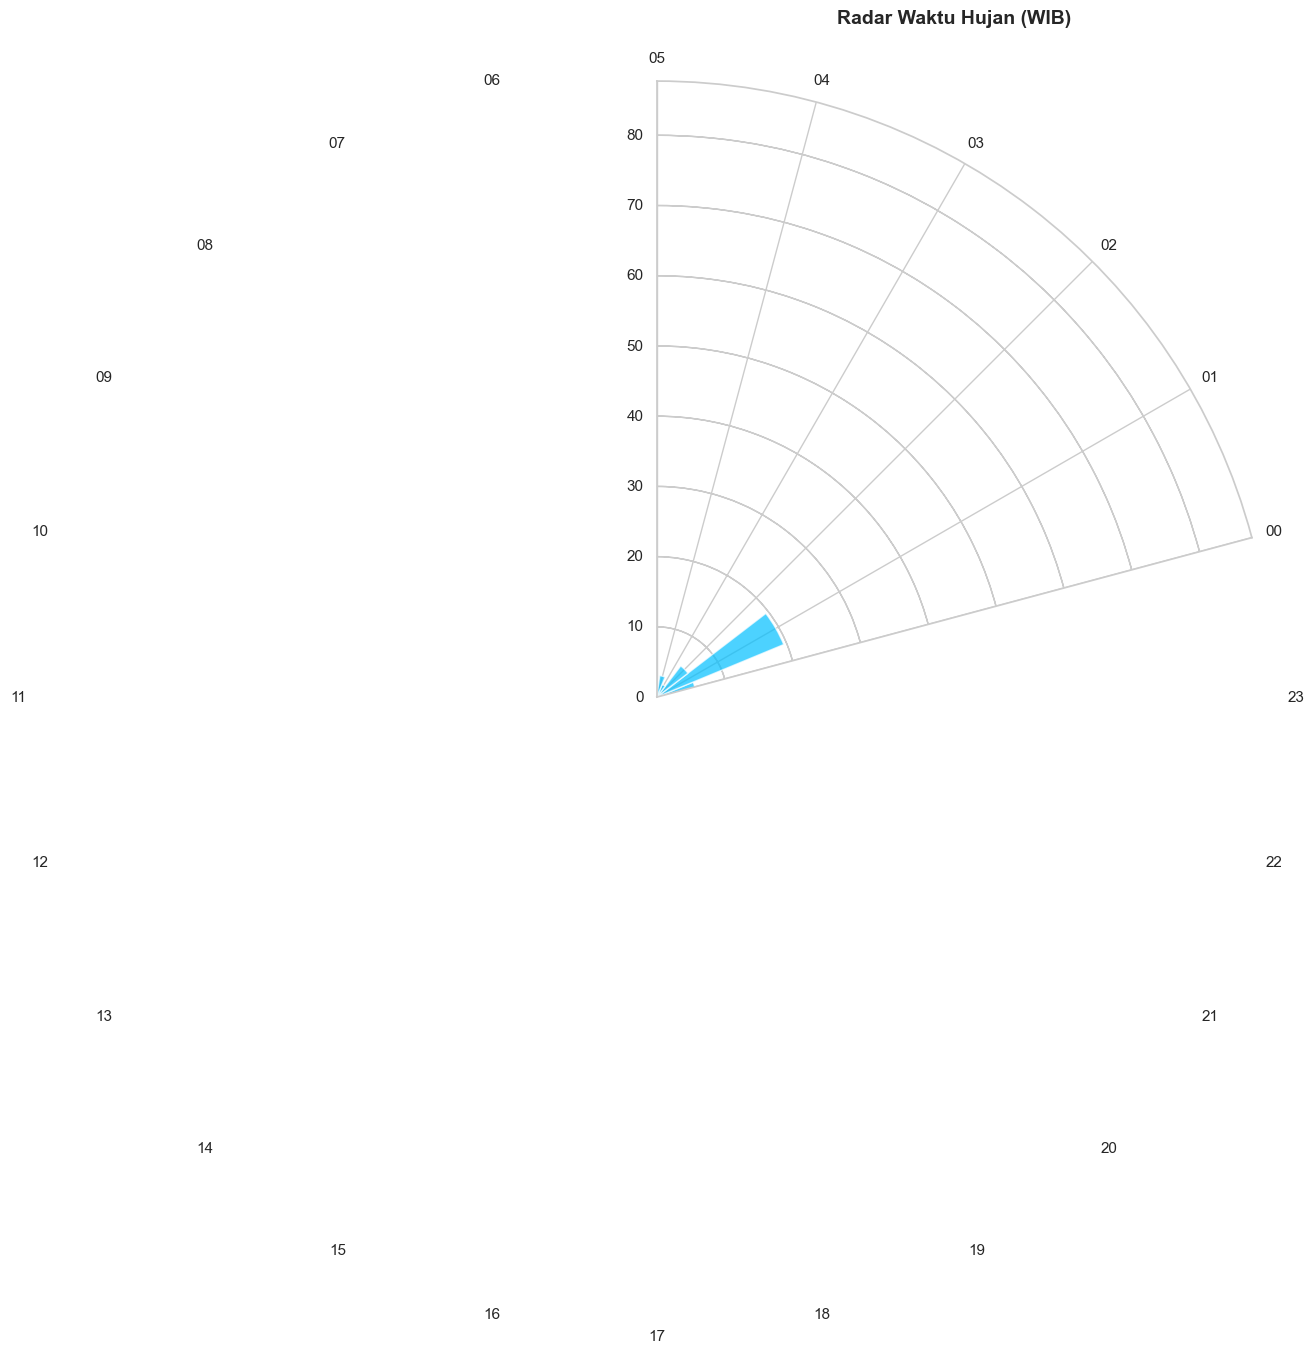

In [67]:
# --- 1. PERSIAPAN DATA ---
# Kita copy dataframe Anda agar data asli aman
df_analisis = data_meteorologi.copy()

# [PENTING] Kembalikan ke WIB (Asia/Jakarta) untuk analisis jam
# Karena pola aktivitas manusia dan matahari mengikuti waktu lokal
df_analisis = df_analisis.tz_convert('Asia/Jakarta')

# Ekstrak jam (0-23) dari index
df_analisis['jam'] = df_analisis.index.hour

# --- 2. HITUNG STATISTIK PER JAM ---

# A. Total Intensitas (Akumulasi 'laju_hujan')
# Menjawab: "Di jam berapa hujan biasanya paling deras?"
# Karena 'laju_hujan' Anda adalah nilai MAX per jam, menjumlahkannya 
# akan menunjukkan jam mana yang sering mendapat intensitas tinggi.
hourly_intensity = df_analisis.groupby('jam')['laju_hujan'].sum()

# B. Frekuensi Kejadian (Peluang)
# Menjawab: "Di jam berapa paling sering terjadi hujan?"
# Kita filter jam dimana laju_hujan > 0.2 (bukan noise)
jam_basah = df_analisis[df_analisis['laju_hujan'] > 0.2]
hourly_freq = jam_basah.groupby('jam')['laju_hujan'].count()

# Gabungkan data (isi 0 jika tidak ada hujan)
df_stats = pd.DataFrame({
    'Total Intensitas': hourly_intensity,
    'Frekuensi': hourly_freq
}).fillna(0)

print("--- Statistik Diurnal (WIB) ---")
print(df_stats.head())

# --- 3. VISUALISASI 1: GRAFIK KOMBO (Bar & Line) ---

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Batang (Intensitas)
ax1.bar(df_stats.index, df_stats['Total Intensitas'], color='dodgerblue', alpha=0.6, label='Akumulasi Intensitas Hujan')
ax1.set_xlabel('Jam (WIB)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Total Intensitas (mm/jam)', color='dodgerblue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='dodgerblue')
ax1.set_xticks(range(0, 24)) 

# Plot Garis (Frekuensi)
ax2 = ax1.twinx()
ax2.plot(df_stats.index, df_stats['Frekuensi'], color='red', marker='o', linewidth=2, label='Frekuensi Kejadian')
ax2.set_ylabel('Frekuensi Kejadian (Kali)', color='red', fontsize=12)
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Siklus Diurnal: Kapan Hujan Turun di Kebumen?', fontsize=14, fontweight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Gabung Legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.show()

# --- 4. VISUALISASI 2: POLAR PLOT (Jam Dinding) ---

# Setup sudut lingkaran (Jam 0-23)
theta = np.linspace(0.0, 2 * np.pi, 24, endpoint=False)
# Geser agar jam 00:00 ada di Atas (Utara), bukan Kanan
theta = theta + np.pi/2 
# Putar arah jarum jam (bukan matematis berlawanan arah)
theta = theta[::-1] 
width = (2*np.pi) / 24

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='polar')

# Plot Data
bars = ax.bar(theta, df_stats['Total Intensitas'], width=width, bottom=0.0, 
              color='deepskyblue', alpha=0.7, edgecolor='white')

# Label Jam
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_xticks(theta)
ax.set_xticklabels([f"{h:02d}" for h in range(24)])

plt.title("Radar Waktu Hujan (WIB)", fontsize=14, fontweight='bold', pad=20)
plt.show()

In [68]:
data_klimat.describe()

curah_hujan  rata_suhu  suhu_maks  suhu_mini
count    26.000000  26.000000  26.000000  26.000000
mean     18.397415  27.660514  31.921531  25.155010
std      21.390831   1.022675   1.853456   0.635053
min       0.000000  25.448301  25.813029  24.152705
25%       1.257300  27.291310  30.996303  24.816904
50%      13.690600  27.787839  32.554004  25.070311
75%      28.359100  28.048083  32.924601  25.413239
max      93.040200  30.905811  34.418785  27.305917

In [69]:
data_meteorologi.describe()

laju_hujan   rata_suhu   suhu_maks   suhu_mini    storm_id
count  591.000000  591.000000  591.000000  591.000000  591.000000
mean     0.809362   27.636288   28.068926   27.206957   51.531303
std      3.504436    2.496599    2.735329    2.294666   32.680248
min      0.000000   24.152705   24.449910   23.750290    1.000000
25%      0.000000   25.588986   25.745020   25.373850   25.000000
50%      0.000000   26.835673   27.146940   26.487370   47.000000
75%      0.000000   29.389309   30.129700   28.897345   85.000000
max     58.674000   34.418785   35.785460   33.982990   99.000000

In [70]:
data_meteorologi['laju_hujan'].sum()

np.float64(478.3327999999999)

In [71]:
data_klimat['curah_hujan'].sum()

np.float64(478.33279999999996)